In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

In [4]:
print(join(data_dir, 'train.csv'))

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv


In [5]:
train_data_path

'/aiffel/aiffel/kaggle_kakr_housing/data/train.csv'

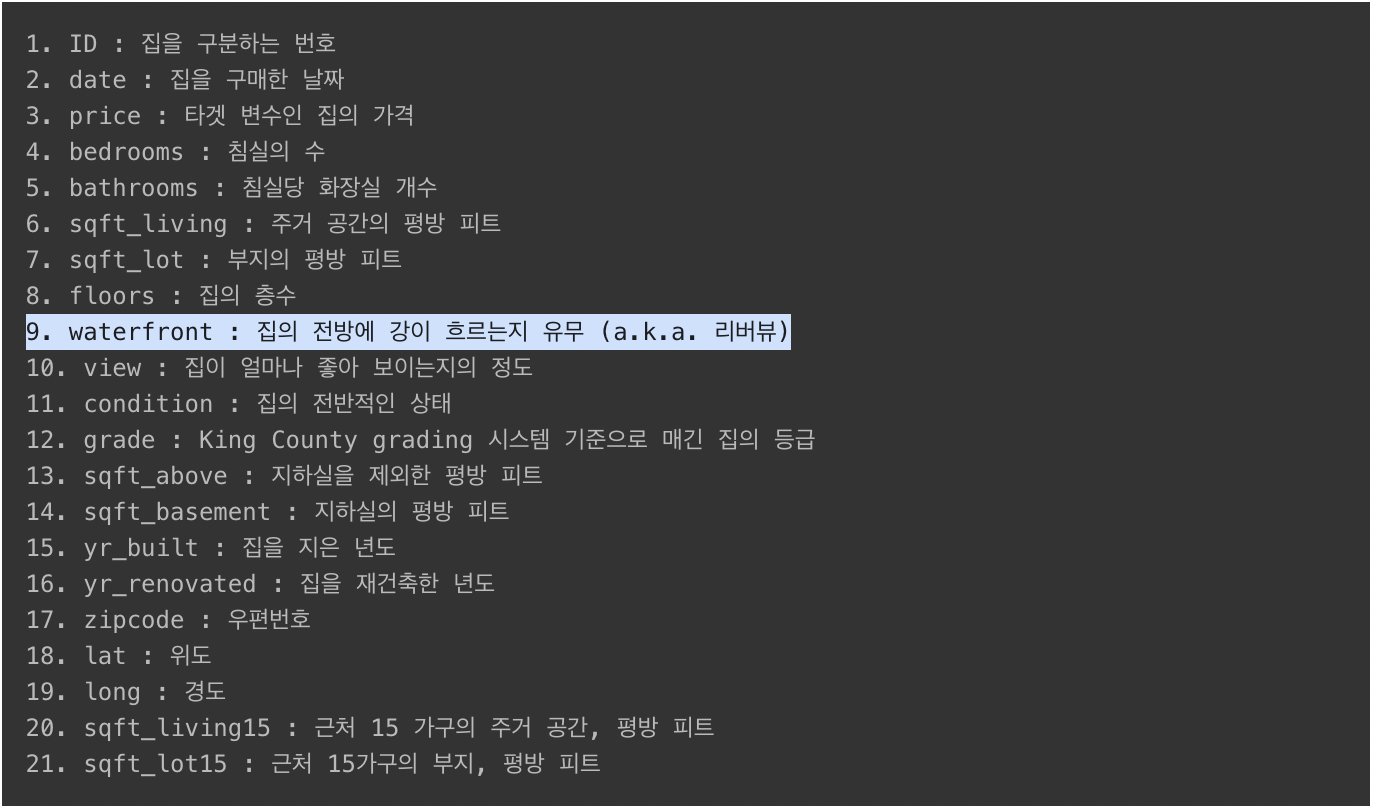  
sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors  
sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

In [6]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

In [7]:
data

id             date      price  bedrooms  bathrooms  sqft_living  \
0          0  20141013T000000   221900.0         3       1.00         1180   
1          1  20150225T000000   180000.0         2       1.00          770   
2          2  20150218T000000   510000.0         3       2.00         1680   
3          3  20140627T000000   257500.0         3       2.25         1715   
4          4  20150115T000000   291850.0         3       1.50         1060   
...      ...              ...        ...       ...        ...          ...   
15030  15030  20141014T000000   610685.0         4       2.50         2520   
15031  15031  20150326T000000  1007500.0         4       3.50         3510   
15032  15032  20140521T000000   360000.0         3       2.50         1530   
15033  15033  20150223T000000   400000.0         4       2.50         2310   
15034  15034  20141015T000000   325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
0          5650     1.0           0     0  ...      7        1180   
1         10000     1.0           0     0  ...      6         770   
2          8080     1.0           0     0  ...      8        1680   
3          6819     2.0           0     0  ...      7        1715   
4          9711     1.0           0     0  ...      7        1060   
...         ...     ...         ...   ...  ...    ...         ...   
15030      6023     2.0           0     0  ...      9        2520   
15031      7200     2.0           0     0  ...      9        2600   
15032      1131     3.0           0     0  ...      8        1530   
15033      5813     2.0           0     0  ...      8        2310   
15034      1076     2.0           0     0  ...      7        1020   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0                  0      1955             0    98178  47.5112 -122.257   
1                  0      1933             0    98028  47.7379 -122.233   
2                  0      1987             0    98074  47.6168 -122.045   
3                  0      1995             0    98003  47.3097 -122.327   
4                  0      1963             0    98198  47.4095 -122.315   
...              ...       ...           ...      ...      ...      ...   
15030              0      2014             0    98056  47.5137 -122.167   
15031            910      2009             0    98136  47.5537 -122.398   
15032              0      2009             0    98103  47.6993 -122.346   
15033              0      2014             0    98146  47.5107 -122.362   
15034              0      2008             0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  
0               1340        5650  
1               2720        8062  
2               1800        7503  
3               2238        6819  
4               1650        9711  
...              ...         ...  
15030           2520        6023  
15031           2050        6200  
15032           1530        1509  
15033           1830        7200  
15034           1020        1357  

[15035 rows x 21 columns]

In [9]:
data.info()
# 15035 rows × 21 columns float64(5), int64(15), object(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [8]:
sub

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0     15035  20141209T000000         3       2.25         2570      7242   
1     15036  20141209T000000         4       3.00         1960      5000   
2     15037  20140512T000000         4       4.50         5420    101930   
3     15038  20150415T000000         3       1.00         1780      7470   
4     15039  20150312T000000         3       2.50         1890      6560   
...     ...              ...       ...        ...          ...       ...   
6463  21498  20140626T000000         3       1.75         1500     11968   
6464  21499  20150126T000000         3       2.00         1490      1126   
6465  21500  20150219T000000         3       2.50         1310      1294   
6466  21501  20140623T000000         2       0.75         1020      1350   
6467  21502  20150116T000000         3       2.50         1600      2388   

      floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
0        2.0           0     0          3      7        2170            400   
1        1.0           0     0          5      7        1050            910   
2        1.0           0     0          3     11        3890           1530   
3        1.0           0     0          3      7        1050            730   
4        2.0           0     0          3      7        1890              0   
...      ...         ...   ...        ...    ...         ...            ...   
6463     1.0           0     0          3      6        1500              0   
6464     3.0           0     0          3      8        1490              0   
6465     2.0           0     0          3      8        1180            130   
6466     2.0           0     0          3      7        1020              0   
6467     2.0           0     0          3      8        1600              0   

      yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0         1951          1991    98125  47.7210 -122.319           1690   
1         1965             0    98136  47.5208 -122.393           1360   
2         2001             0    98053  47.6561 -122.005           4760   
3         1960             0    98146  47.5123 -122.337           1780   
4         2003             0    98038  47.3684 -122.031           2390   
...        ...           ...      ...      ...      ...            ...   
6463      2014             0    98010  47.3095 -122.002           1320   
6464      2014             0    98144  47.5699 -122.288           1400   
6465      2008             0    98116  47.5773 -122.409           1330   
6466      2009             0    98144  47.5944 -122.299           1020   
6467      2004             0    98027  47.5345 -122.069           1410   

      sqft_lot15  
0           7639  
1           5000  
2         101930  
3           8113  
4           7570  
...          ...  
6463       11303  
6464        1230  
6465        1265  
6466        2007  
6467        1287  

[6468 rows x 20 columns]

In [10]:
sub.info()
#6468 rows × 20 columns float64(4), int64(15), object(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

In [14]:
data.columns
# price

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [15]:
sub.columns
# not "price"

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [16]:
y = data['price']
del data['price']

In [17]:
data.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [19]:
len(data.columns)

20

In [22]:
data

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0          0  20141013T000000         3       1.00         1180      5650   
1          1  20150225T000000         2       1.00          770     10000   
2          2  20150218T000000         3       2.00         1680      8080   
3          3  20140627T000000         3       2.25         1715      6819   
4          4  20150115T000000         3       1.50         1060      9711   
...      ...              ...       ...        ...          ...       ...   
15030  15030  20141014T000000         4       2.50         2520      6023   
15031  15031  20150326T000000         4       3.50         3510      7200   
15032  15032  20140521T000000         3       2.50         1530      1131   
15033  15033  20150223T000000         4       2.50         2310      5813   
15034  15034  20141015T000000         2       0.75         1020      1076   

       floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
0         1.0           0     0          3      7        1180              0   
1         1.0           0     0          3      6         770              0   
2         1.0           0     0          3      8        1680              0   
3         2.0           0     0          3      7        1715              0   
4         1.0           0     0          3      7        1060              0   
...       ...         ...   ...        ...    ...         ...            ...   
15030     2.0           0     0          3      9        2520              0   
15031     2.0           0     0          3      9        2600            910   
15032     3.0           0     0          3      8        1530              0   
15033     2.0           0     0          3      8        2310              0   
15034     2.0           0     0          3      7        1020              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0          1955             0    98178  47.5112 -122.257           1340   
1          1933             0    98028  47.7379 -122.233           2720   
2          1987             0    98074  47.6168 -122.045           1800   
3          1995             0    98003  47.3097 -122.327           2238   
4          1963             0    98198  47.4095 -122.315           1650   
...         ...           ...      ...      ...      ...            ...   
15030      2014             0    98056  47.5137 -122.167           2520   
15031      2009             0    98136  47.5537 -122.398           2050   
15032      2009             0    98103  47.6993 -122.346           1530   
15033      2014             0    98146  47.5107 -122.362           1830   
15034      2008             0    98144  47.5941 -122.299           1020   

       sqft_lot15  
0            5650  
1            8062  
2            7503  
3            6819  
4            9711  
...           ...  
15030        6023  
15031        6200  
15032        1509  
15033        7200  
15034        1357  

[15035 rows x 20 columns]

In [23]:
sub

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0     15035  20141209T000000         3       2.25         2570      7242   
1     15036  20141209T000000         4       3.00         1960      5000   
2     15037  20140512T000000         4       4.50         5420    101930   
3     15038  20150415T000000         3       1.00         1780      7470   
4     15039  20150312T000000         3       2.50         1890      6560   
...     ...              ...       ...        ...          ...       ...   
6463  21498  20140626T000000         3       1.75         1500     11968   
6464  21499  20150126T000000         3       2.00         1490      1126   
6465  21500  20150219T000000         3       2.50         1310      1294   
6466  21501  20140623T000000         2       0.75         1020      1350   
6467  21502  20150116T000000         3       2.50         1600      2388   

      floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
0        2.0           0     0          3      7        2170            400   
1        1.0           0     0          5      7        1050            910   
2        1.0           0     0          3     11        3890           1530   
3        1.0           0     0          3      7        1050            730   
4        2.0           0     0          3      7        1890              0   
...      ...         ...   ...        ...    ...         ...            ...   
6463     1.0           0     0          3      6        1500              0   
6464     3.0           0     0          3      8        1490              0   
6465     2.0           0     0          3      8        1180            130   
6466     2.0           0     0          3      7        1020              0   
6467     2.0           0     0          3      8        1600              0   

      yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0         1951          1991    98125  47.7210 -122.319           1690   
1         1965             0    98136  47.5208 -122.393           1360   
2         2001             0    98053  47.6561 -122.005           4760   
3         1960             0    98146  47.5123 -122.337           1780   
4         2003             0    98038  47.3684 -122.031           2390   
...        ...           ...      ...      ...      ...            ...   
6463      2014             0    98010  47.3095 -122.002           1320   
6464      2014             0    98144  47.5699 -122.288           1400   
6465      2008             0    98116  47.5773 -122.409           1330   
6466      2009             0    98144  47.5944 -122.299           1020   
6467      2004             0    98027  47.5345 -122.069           1410   

      sqft_lot15  
0           7639  
1           5000  
2         101930  
3           8113  
4           7570  
...          ...  
6463       11303  
6464        1230  
6465        1265  
6466        2007  
6467        1287  

[6468 rows x 20 columns]

In [24]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

train['id'] 15034까지  
sub['id'] 15035 부터 이기에 axis= 0 

In [25]:
data

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0         0  20141013T000000         3       1.00         1180      5650   
1         1  20150225T000000         2       1.00          770     10000   
2         2  20150218T000000         3       2.00         1680      8080   
3         3  20140627T000000         3       2.25         1715      6819   
4         4  20150115T000000         3       1.50         1060      9711   
...     ...              ...       ...        ...          ...       ...   
6463  21498  20140626T000000         3       1.75         1500     11968   
6464  21499  20150126T000000         3       2.00         1490      1126   
6465  21500  20150219T000000         3       2.50         1310      1294   
6466  21501  20140623T000000         2       0.75         1020      1350   
6467  21502  20150116T000000         3       2.50         1600      2388   

      floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
0        1.0           0     0          3      7        1180              0   
1        1.0           0     0          3      6         770              0   
2        1.0           0     0          3      8        1680              0   
3        2.0           0     0          3      7        1715              0   
4        1.0           0     0          3      7        1060              0   
...      ...         ...   ...        ...    ...         ...            ...   
6463     1.0           0     0          3      6        1500              0   
6464     3.0           0     0          3      8        1490              0   
6465     2.0           0     0          3      8        1180            130   
6466     2.0           0     0          3      7        1020              0   
6467     2.0           0     0          3      8        1600              0   

      yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0         1955             0    98178  47.5112 -122.257           1340   
1         1933             0    98028  47.7379 -122.233           2720   
2         1987             0    98074  47.6168 -122.045           1800   
3         1995             0    98003  47.3097 -122.327           2238   
4         1963             0    98198  47.4095 -122.315           1650   
...        ...           ...      ...      ...      ...            ...   
6463      2014             0    98010  47.3095 -122.002           1320   
6464      2014             0    98144  47.5699 -122.288           1400   
6465      2008             0    98116  47.5773 -122.409           1330   
6466      2009             0    98144  47.5944 -122.299           1020   
6467      2004             0    98027  47.5345 -122.069           1410   

      sqft_lot15  
0           5650  
1           8062  
2           7503  
3           6819  
4           9711  
...          ...  
6463       11303  
6464        1230  
6465        1265  
6466        2007  
6467        1287  

[21503 rows x 20 columns]

In [26]:
len(data)

21503

## import missingno as msno
### msno.matrix
> 결측치를 시각화

(
    df,
    filter=None,
    n=0,
    p=0,
    sort=None,
    figsize=(25, 10),
    width_ratios=(15, 1),
    color=(0.25, 0.25, 0.25),
    fontsize=16,
    labels=None,
    sparkline=True,
    inline=False,
    freq=None,
    ax=None,
)

<AxesSubplot:>

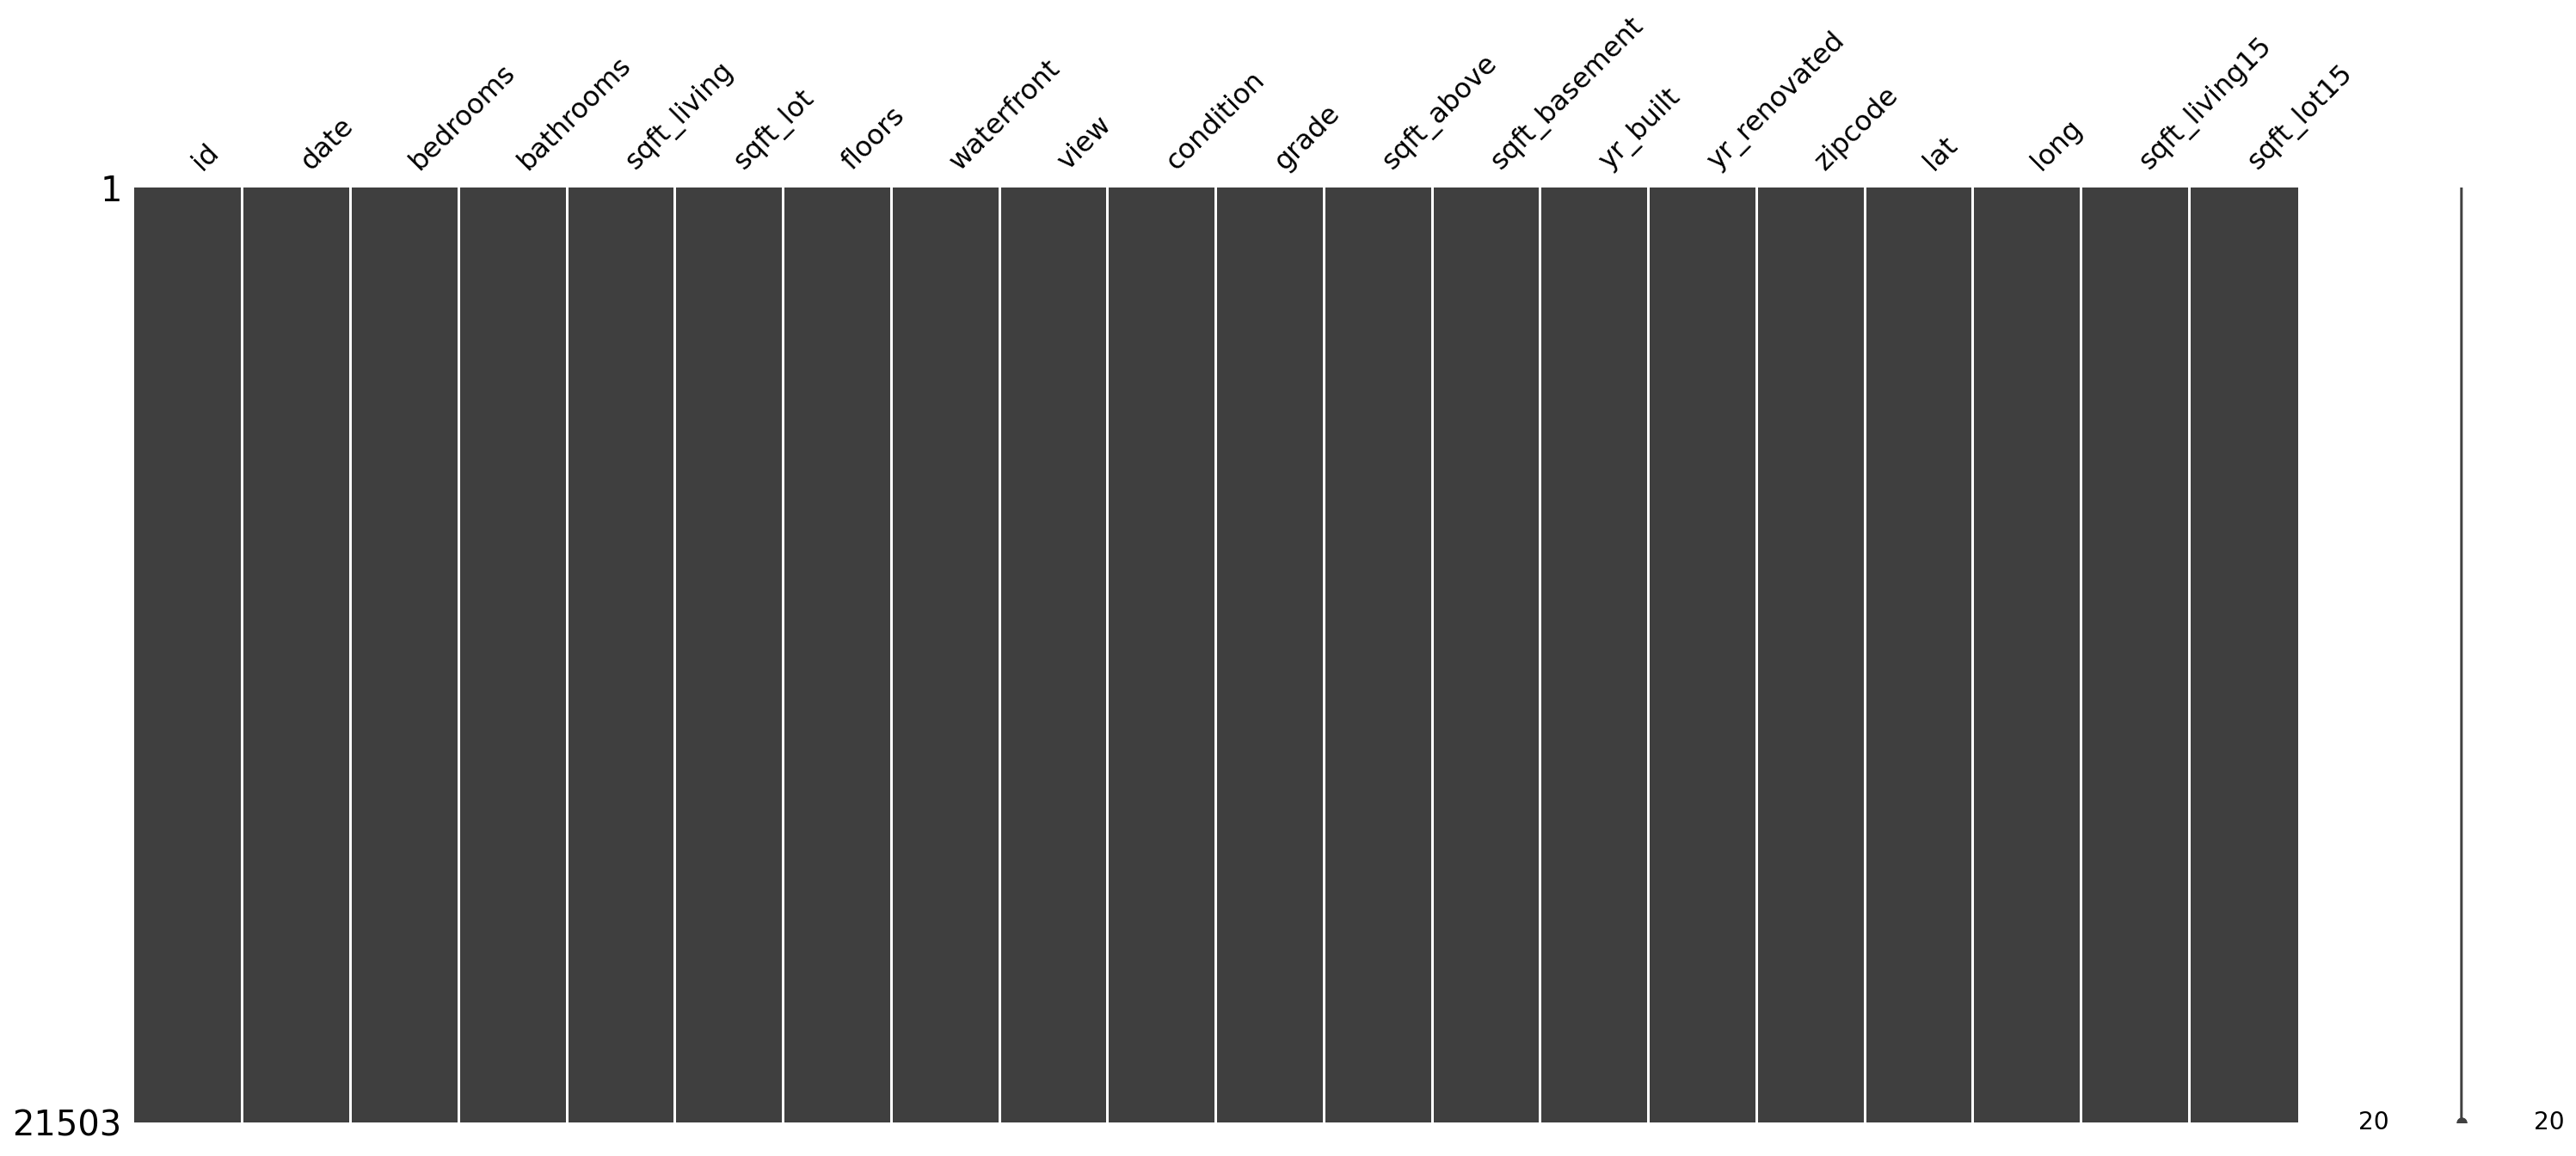

In [27]:
msno.matrix(data)

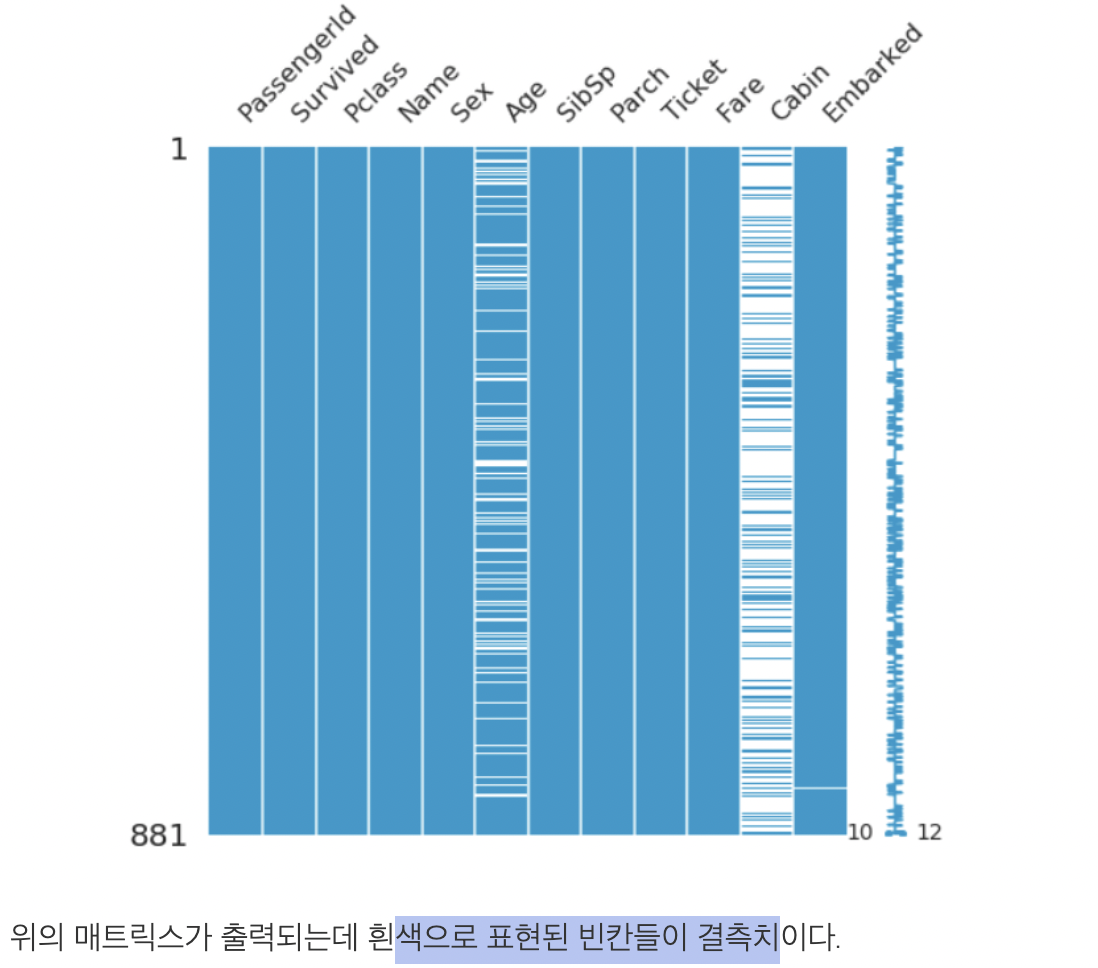
https://hong-yp-ml-records.tistory.com/14

In [29]:
data['id'].isnull().sum()

0

In [32]:
data[['id']].isnull().sum()

id    0
dtype: int64

In [33]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [40]:
data.loc[null_check, "id"]

Series([], Name: id, dtype: int64)

In [41]:
null_data = data.loc[null_check, 'id']
null_data

Series([], Name: id, dtype: int64)

In [42]:
# 3. 결측치인 데이터의 개수를 셉니다.
print(f'id: {len(null_data.values)}')

id: 0


In [55]:
null_data.values

array([], dtype=int64)

In [49]:
null_data.sum()

0

In [50]:
print('{} : {}'.format('id', len(data.loc[null_data, 'id'].values)))

id : 0


In [57]:
for c in data.columns:
    print(c)

id
date
bedrooms
bathrooms
sqft_living
sqft_lot
floors
waterfront
view
condition
grade
sqft_above
sqft_basement
yr_built
yr_renovated
zipcode
lat
long
sqft_living15
sqft_lot15


In [58]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [61]:
# concatenate한 후 train data의 rows
len(data)

21503

In [62]:
# concatenate하기 전 train data rows
train_len

15035

In [64]:
#sub data의 rows
data['id'][train_len:]
#data["id"][15035:]
# 6468 rows

0       15035
1       15036
2       15037
3       15038
4       15039
        ...  
6463    21498
6464    21499
6465    21500
6466    21501
6467    21502
Name: id, Length: 6468, dtype: int64

In [65]:
sub_id = data['id'][train_len:]
del data['id']

In [71]:
data.columns.value_counts().sum()

19

In [72]:
len(data.columns)

19

In [73]:
data['date']

0       20141013T000000
1       20150225T000000
2       20150218T000000
3       20140627T000000
4       20150115T000000
             ...       
6463    20140626T000000
6464    20150126T000000
6465    20150219T000000
6466    20140623T000000
6467    20150116T000000
Name: date, Length: 21503, dtype: object

In [82]:
type(data['date'])

pandas.core.series.Series

In [83]:
data['date'].dtype

dtype('O')

In [89]:
type(data['date'].apply)

method

In [78]:
data['date'].str[:6]

0       201410
1       201502
2       201502
3       201406
4       201501
         ...  
6463    201406
6464    201501
6465    201502
6466    201406
6467    201501
Name: date, Length: 21503, dtype: object

In [90]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

In [91]:
data

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0     201410         3       1.00         1180      5650     1.0           0   
1     201502         2       1.00          770     10000     1.0           0   
2     201502         3       2.00         1680      8080     1.0           0   
3     201406         3       2.25         1715      6819     2.0           0   
4     201501         3       1.50         1060      9711     1.0           0   
...      ...       ...        ...          ...       ...     ...         ...   
6463  201406         3       1.75         1500     11968     1.0           0   
6464  201501         3       2.00         1490      1126     3.0           0   
6465  201502         3       2.50         1310      1294     2.0           0   
6466  201406         2       0.75         1020      1350     2.0           0   
6467  201501         3       2.50         1600      2388     2.0           0   

      view  condition  grade  sqft_above  sqft_basement  yr_built  \
0        0          3      7        1180              0      1955   
1        0          3      6         770              0      1933   
2        0          3      8        1680              0      1987   
3        0          3      7        1715              0      1995   
4        0          3      7        1060              0      1963   
...    ...        ...    ...         ...            ...       ...   
6463     0          3      6        1500              0      2014   
6464     0          3      8        1490              0      2014   
6465     0          3      8        1180            130      2008   
6466     0          3      7        1020              0      2009   
6467     0          3      8        1600              0      2004   

      yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0                0    98178  47.5112 -122.257           1340        5650  
1                0    98028  47.7379 -122.233           2720        8062  
2                0    98074  47.6168 -122.045           1800        7503  
3                0    98003  47.3097 -122.327           2238        6819  
4                0    98198  47.4095 -122.315           1650        9711  
...            ...      ...      ...      ...            ...         ...  
6463             0    98010  47.3095 -122.002           1320       11303  
6464             0    98144  47.5699 -122.288           1400        1230  
6465             0    98116  47.5773 -122.409           1330        1265  
6466             0    98144  47.5944 -122.299           1020        2007  
6467             0    98027  47.5345 -122.069           1410        1287  

[21503 rows x 19 columns]

In [107]:
data.columns[1]

'bedrooms'

In [114]:
data.columns[1][0]

'b'

ax[row][col]
>AxesSubplot(0.125,0.808774;0.352273x0.0712264)
AxesSubplot(0.547727,0.808774;0.352273x0.0712264)
AxesSubplot(0.125,0.723302;0.352273x0.0712264)
AxesSubplot(0.547727,0.723302;0.352273x0.0712264)
AxesSubplot(0.125,0.63783;0.352273x0.0712264)
AxesSubplot(0.547727,0.63783;0.352273x0.0712264)
AxesSubplot(0.125,0.552358;0.352273x0.0712264)
AxesSubplot(0.547727,0.552358;0.352273x0.0712264)
AxesSubplot(0.125,0.466887;0.352273x0.0712264)
AxesSubplot(0.547727,0.466887;0.352273x0.0712264)
AxesSubplot(0.125,0.381415;0.352273x0.0712264)
AxesSubplot(0.547727,0.381415;0.352273x0.0712264)
AxesSubplot(0.125,0.295943;0.352273x0.0712264)
AxesSubplot(0.547727,0.295943;0.352273x0.0712264)
AxesSubplot(0.125,0.210472;0.352273x0.0712264)
AxesSubplot(0.547727,0.210472;0.352273x0.0712264)
AxesSubplot(0.125,0.125;0.352273x0.0712264)
AxesSubplot(0.547727,0.125;0.352273x0.0712264)

ax[row]
>[<AxesSubplot:xlabel='bedrooms', ylabel='Density'> <AxesSubplot:>]
[<AxesSubplot:title={'center':'bedrooms'}, xlabel='bedrooms', ylabel='Density'>
 <AxesSubplot:xlabel='bathrooms', ylabel='Density'>]
[<AxesSubplot:xlabel='sqft_living', ylabel='Density'> <AxesSubplot:>]
[<AxesSubplot:title={'center':'sqft_living'}, xlabel='sqft_living', ylabel='Density'>
 <AxesSubplot:xlabel='sqft_lot', ylabel='Density'>]
[<AxesSubplot:xlabel='floors', ylabel='Density'> <AxesSubplot:>]
[<AxesSubplot:title={'center':'floors'}, xlabel='floors', ylabel='Density'>
 <AxesSubplot:xlabel='waterfront', ylabel='Density'>]
[<AxesSubplot:xlabel='view', ylabel='Density'> <AxesSubplot:>]
[<AxesSubplot:title={'center':'view'}, xlabel='view', ylabel='Density'>
 <AxesSubplot:xlabel='condition', ylabel='Density'>]
[<AxesSubplot:xlabel='grade', ylabel='Density'> <AxesSubplot:>]
[<AxesSubplot:title={'center':'grade'}, xlabel='grade', ylabel='Density'>
 <AxesSubplot:xlabel='sqft_above', ylabel='Density'>]
[<AxesSubplot:xlabel='sqft_basement', ylabel='Density'> <AxesSubplot:>]
[<AxesSubplot:title={'center':'sqft_basement'}, xlabel='sqft_basement', ylabel='Density'>
 <AxesSubplot:xlabel='yr_built', ylabel='Density'>]
[<AxesSubplot:xlabel='yr_renovated', ylabel='Density'> <AxesSubplot:>]
[<AxesSubplot:title={'center':'yr_renovated'}, xlabel='yr_renovated', ylabel='Density'>
 <AxesSubplot:xlabel='zipcode', ylabel='Density'>]
[<AxesSubplot:xlabel='lat', ylabel='Density'> <AxesSubplot:>]
[<AxesSubplot:title={'center':'lat'}, xlabel='lat', ylabel='Density'>
 <AxesSubplot:xlabel='long', ylabel='Density'>]
[<AxesSubplot:xlabel='sqft_living15', ylabel='Density'> <AxesSubplot:>]
[<AxesSubplot:title={'center':'sqft_living15'}, xlabel='sqft_living15', ylabel='Density'>
 <AxesSubplot:xlabel='sqft_lot15', ylabel='Density'>]

납득 못함
ax[row][col]

In [130]:
ax[row][col]

<AxesSubplot:>

<AxesSubplot:xlabel='bedrooms', ylabel='Density'>

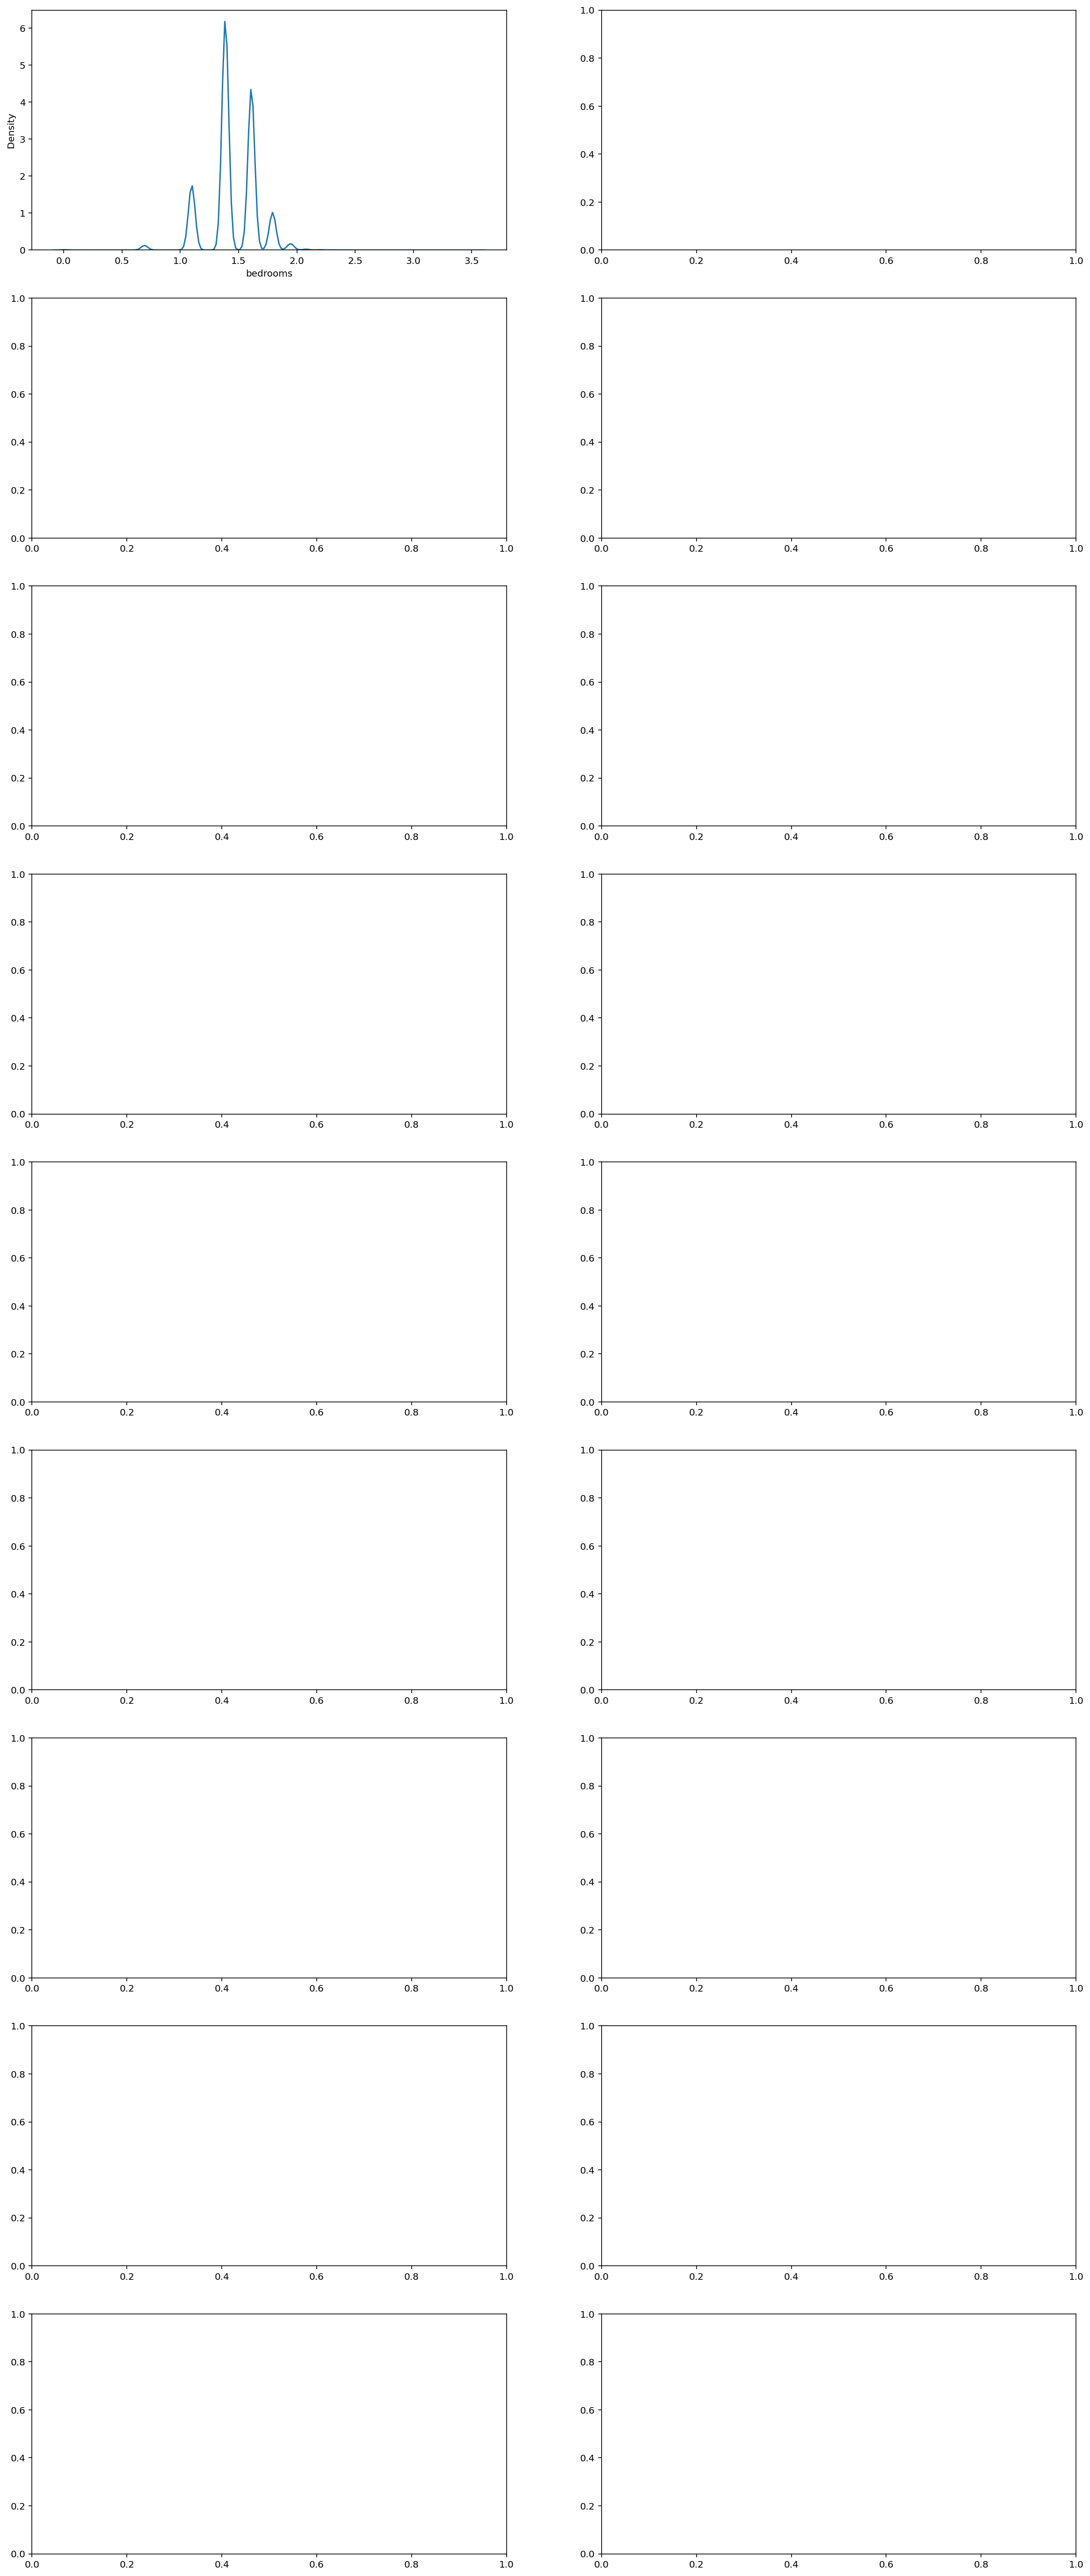

In [134]:
fig, ax = plt.subplots(9, 2, figsize=(20, 50))

sns.kdeplot(data= data[columns[1]], ax= ax[0][0])

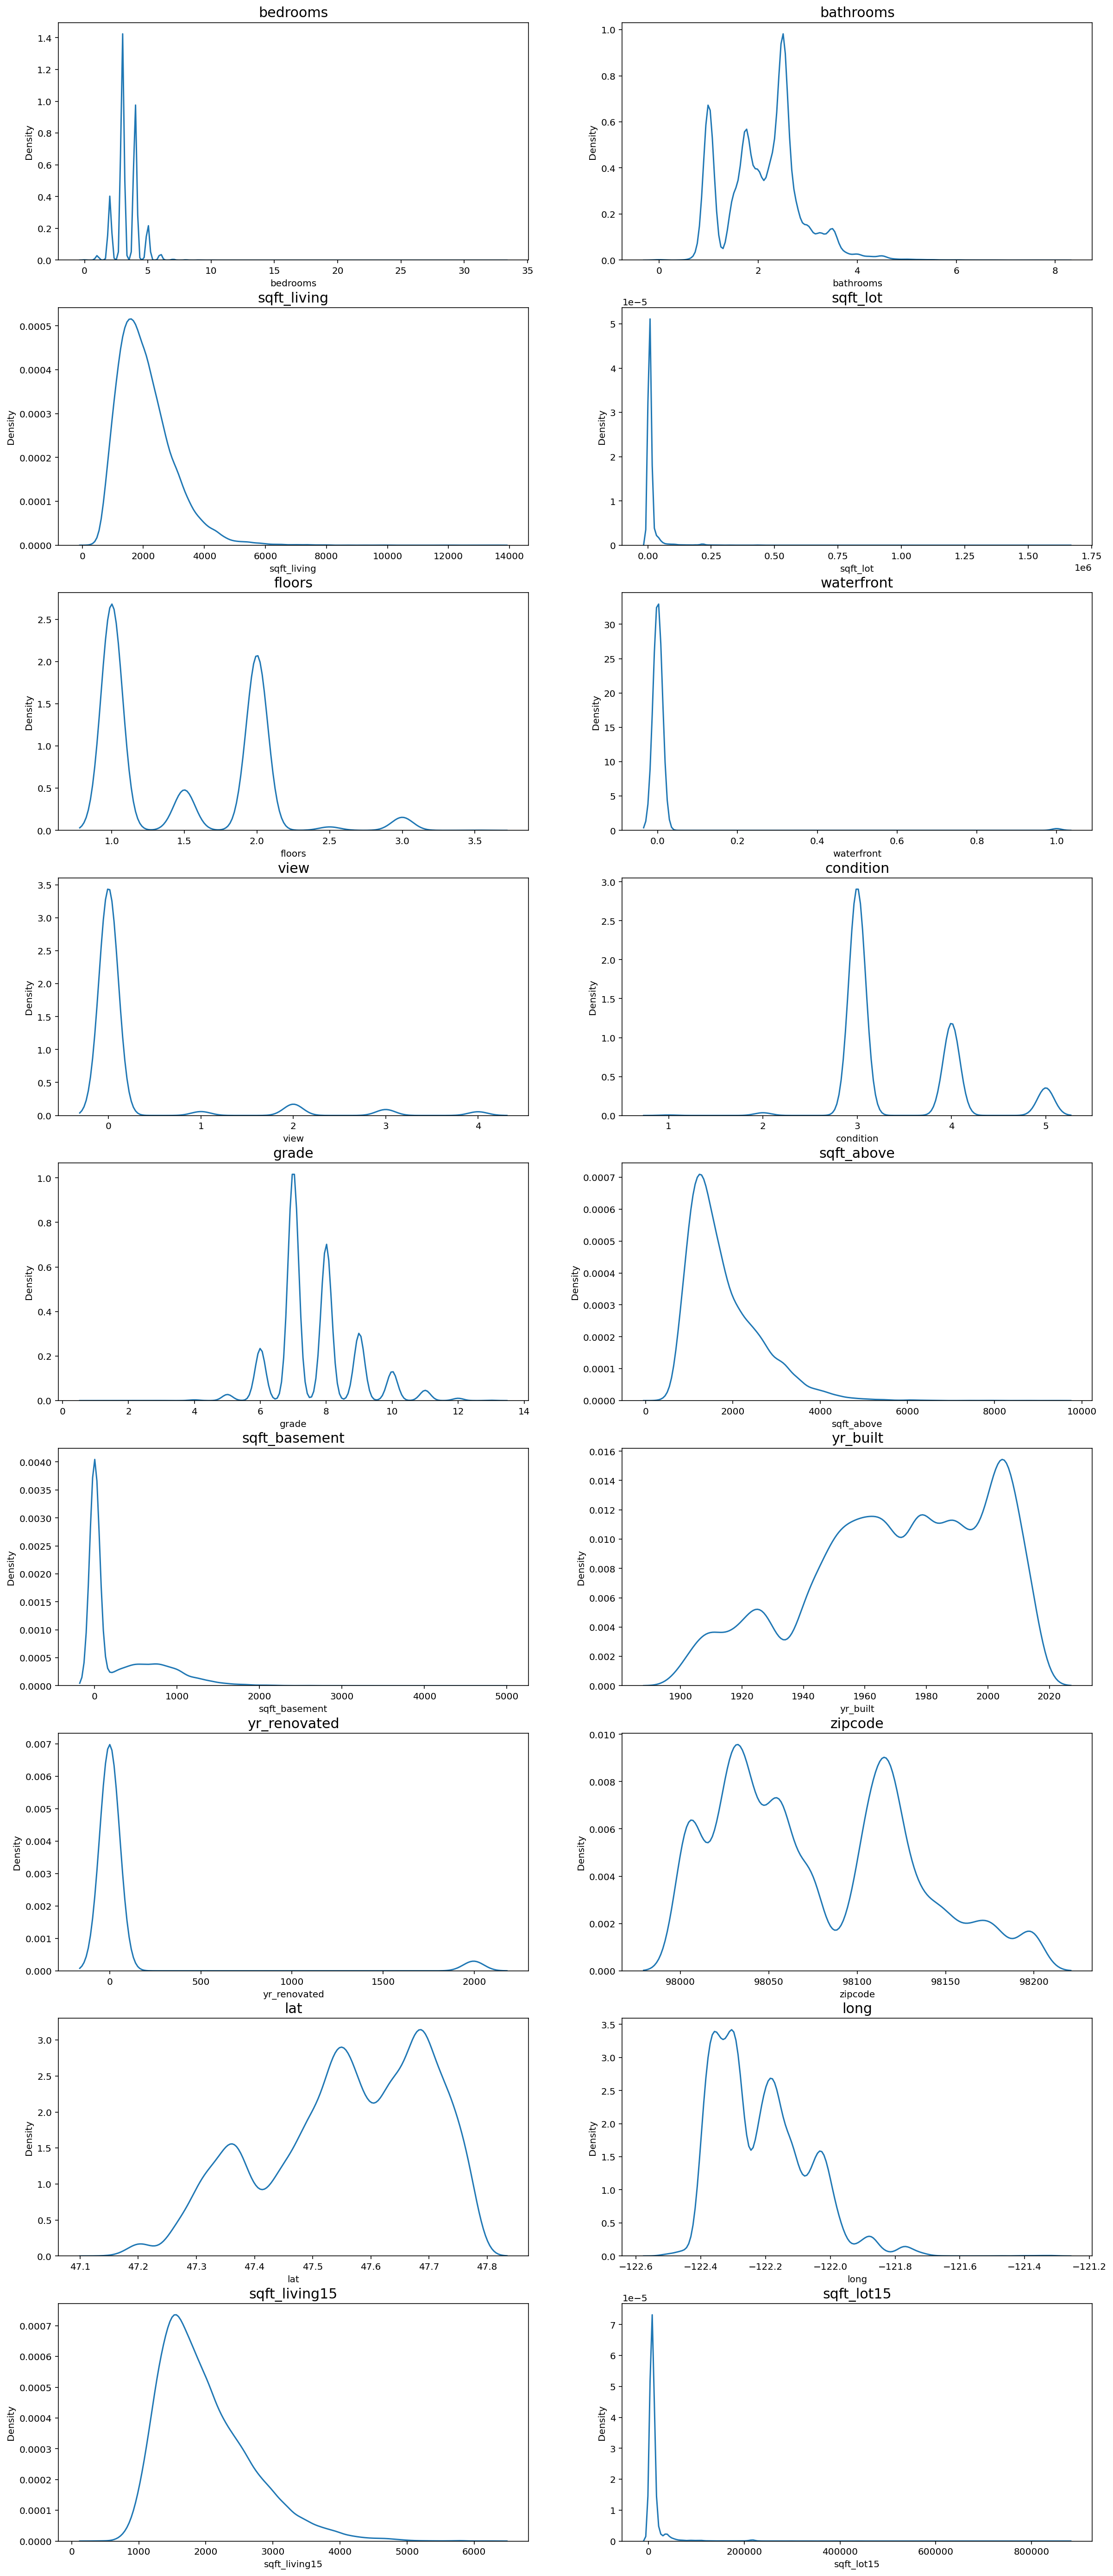

In [112]:
fig, ax = plt.subplots(9, 2, figsize=(20, 50))
# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data= data[columns[count]], ax= ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

np.log1p
>Return the natural logarithm of one plus the input array, element-wise.  
> log(1 + x)

np.expm1
> Calculate exp(x) - 1 for all elements in the array.

In [119]:
data["bedrooms"]

0       1.386294
1       1.098612
2       1.386294
3       1.386294
4       1.386294
          ...   
6463    1.386294
6464    1.386294
6465    1.386294
6466    1.098612
6467    1.386294
Name: bedrooms, Length: 21503, dtype: float64

In [115]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

In [116]:
data[c]

0       7.201171
1       7.908755
2       7.496097
3       7.713785
4       7.409136
          ...   
6463    7.186144
6464    7.244942
6465    7.193686
6466    6.928538
6467    7.252054
Name: sqft_living15, Length: 21503, dtype: float64

In [117]:
data[c].values

array([7.20117088, 7.90875474, 7.49609735, ..., 7.19368582, 6.92853782,
       7.25205395])

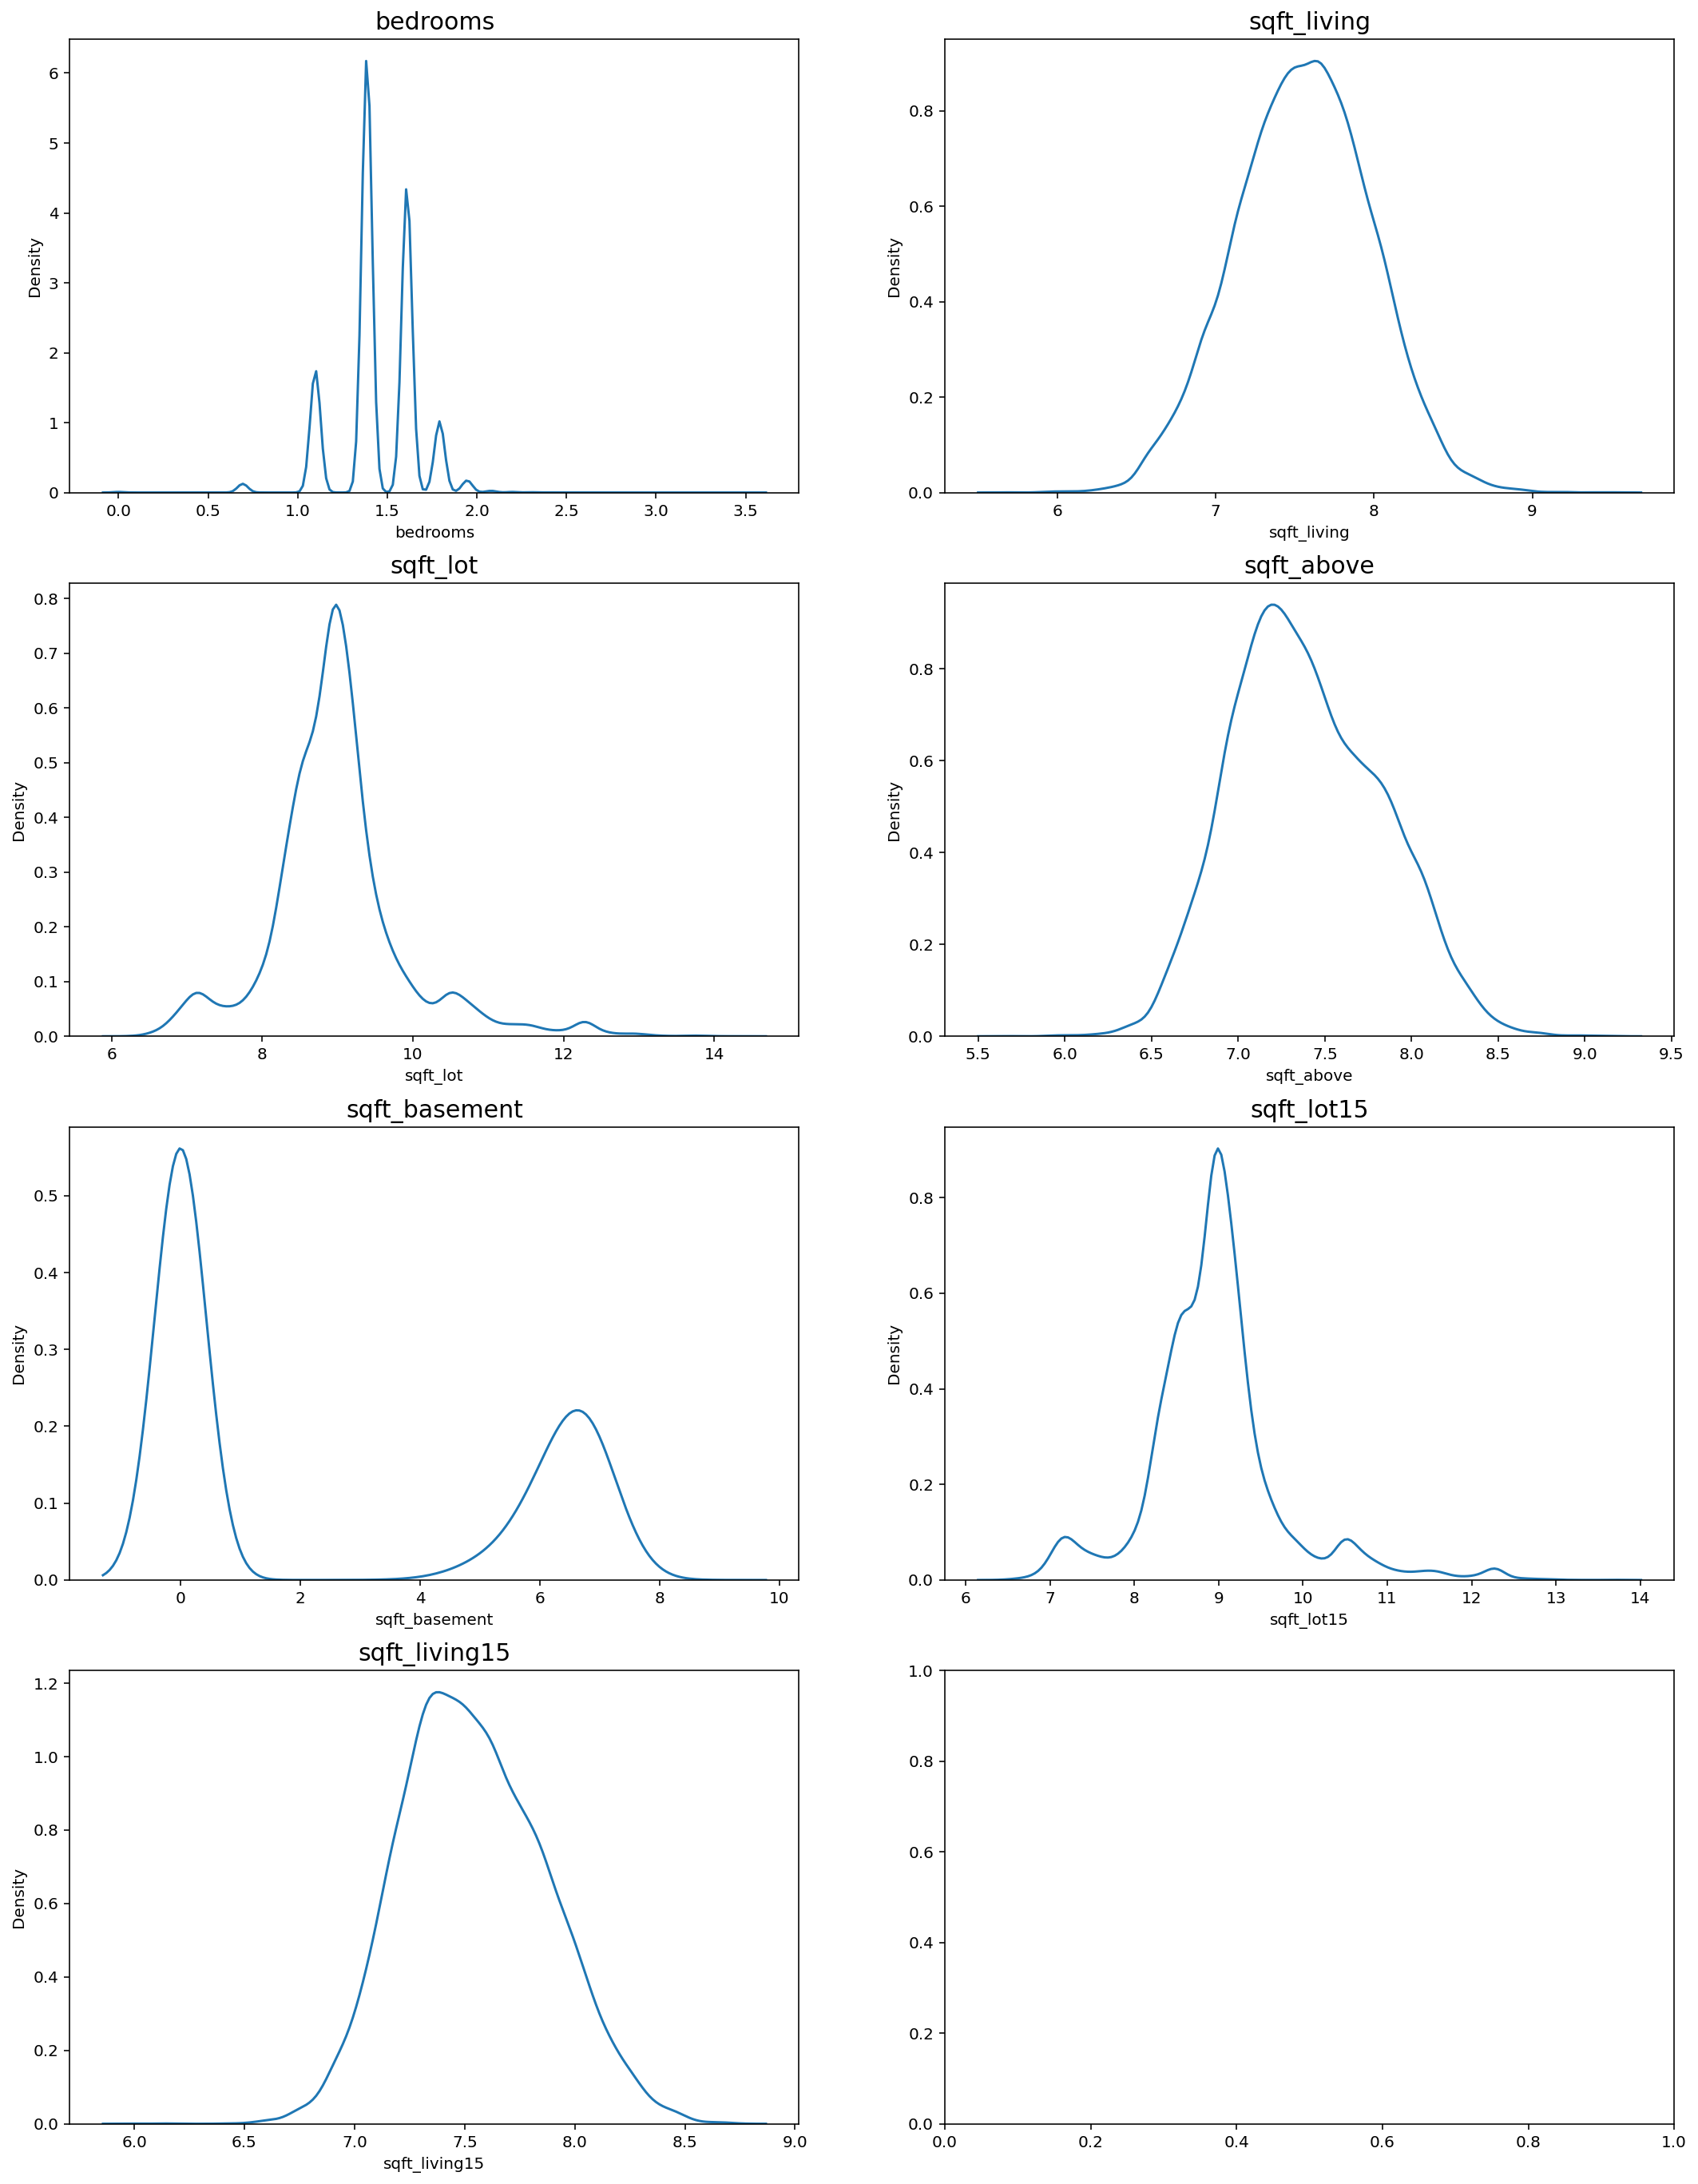

In [120]:
fig, ax = plt.subplots(4, 2, figsize=(18, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

### np.linspace
#### Return evenly spaced numbers over a specified interval.
>(
    start,
    stop,
    num=50,
    endpoint=True,
    retstep=False,
    dtype=None,
    axis=0,
)

In [121]:
np.linspace(0, 10, 500)

array([ 0.        ,  0.02004008,  0.04008016,  0.06012024,  0.08016032,
        0.1002004 ,  0.12024048,  0.14028056,  0.16032064,  0.18036072,
        0.2004008 ,  0.22044088,  0.24048096,  0.26052104,  0.28056112,
        0.3006012 ,  0.32064128,  0.34068136,  0.36072144,  0.38076152,
        0.4008016 ,  0.42084168,  0.44088176,  0.46092184,  0.48096192,
        0.501002  ,  0.52104208,  0.54108216,  0.56112224,  0.58116232,
        0.6012024 ,  0.62124248,  0.64128257,  0.66132265,  0.68136273,
        0.70140281,  0.72144289,  0.74148297,  0.76152305,  0.78156313,
        0.80160321,  0.82164329,  0.84168337,  0.86172345,  0.88176353,
        0.90180361,  0.92184369,  0.94188377,  0.96192385,  0.98196393,
        1.00200401,  1.02204409,  1.04208417,  1.06212425,  1.08216433,
        1.10220441,  1.12224449,  1.14228457,  1.16232465,  1.18236473,
        1.20240481,  1.22244489,  1.24248497,  1.26252505,  1.28256513,
        1.30260521,  1.32264529,  1.34268537,  1.36272545,  1.38

In [127]:
yy

array([           -inf, -3.91002100e+00, -3.21687382e+00, -2.81140871e+00,
       -2.52372664e+00, -2.30058309e+00, -2.11826153e+00, -1.96411085e+00,
       -1.83057946e+00, -1.71279643e+00, -1.60743591e+00, -1.51212573e+00,
       -1.42511435e+00, -1.34507165e+00, -1.27096367e+00, -1.20197080e+00,
       -1.13743228e+00, -1.07680766e+00, -1.01964924e+00, -9.65582024e-01,
       -9.14288729e-01, -8.65498565e-01, -8.18978549e-01, -7.74526787e-01,
       -7.31967172e-01, -6.91145178e-01, -6.51924465e-01, -6.14184137e-01,
       -5.77816493e-01, -5.42725173e-01, -5.08823621e-01, -4.76033798e-01,
       -4.44285100e-01, -4.13513441e-01, -3.83660478e-01, -3.54672941e-01,
       -3.26502064e-01, -2.99103090e-01, -2.72434843e-01, -2.46459357e-01,
       -2.21141549e-01, -1.96448936e-01, -1.72351384e-01, -1.48820887e-01,
       -1.25831369e-01, -1.03358513e-01, -8.13796063e-02, -5.98734010e-02,
       -3.88199918e-02, -1.82007046e-02,  2.00200267e-03,  2.18046300e-02,
        4.12227158e-02,  

### plt.hlines
#### Plot horizontal lines at each *y* from *xmin* to *xmax*
>(
    y,
    xmin,
    xmax,
    colors=None,
    linestyles='solid',
    label='',
    *,
    data=None,
    **kwargs,
)
### plt.vlines
#### Plot vertical lines at each *x* from *ymin* to *ymax*.
>(
    x,
    ymin,
    ymax,
    colors=None,
    linestyles='solid',
    label='',
    *,
    data=None,
    **kwargs,
)

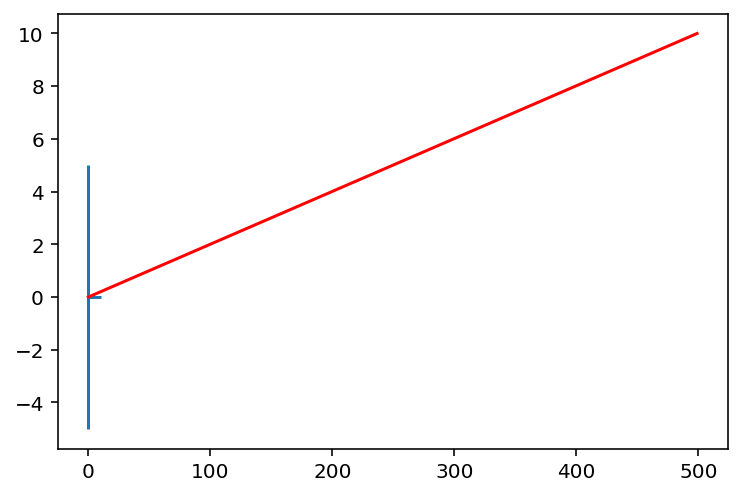

In [124]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, c='r')
plt.show()

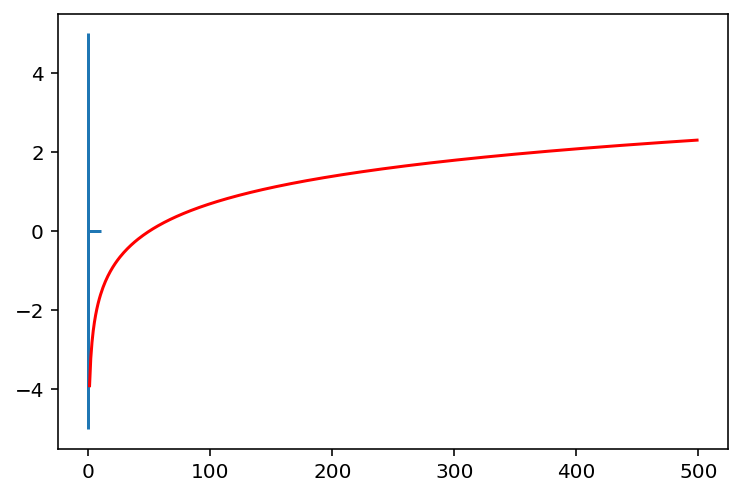

In [125]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(yy, c='r')
plt.show()

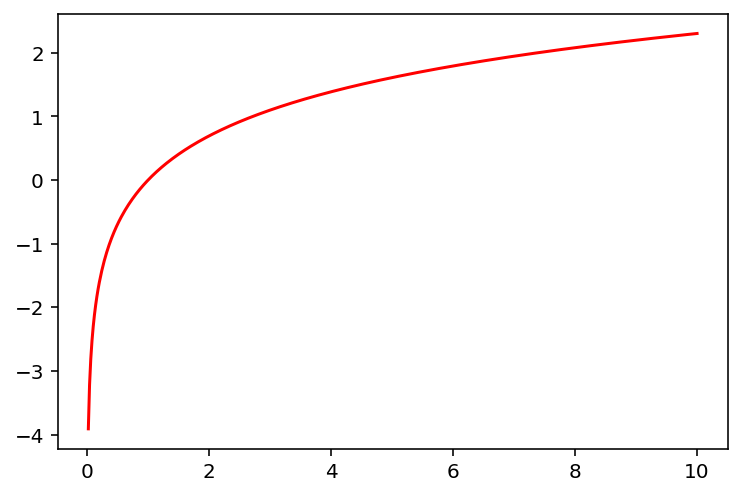

In [129]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

# plt.hlines(0, 0, 10)
# plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

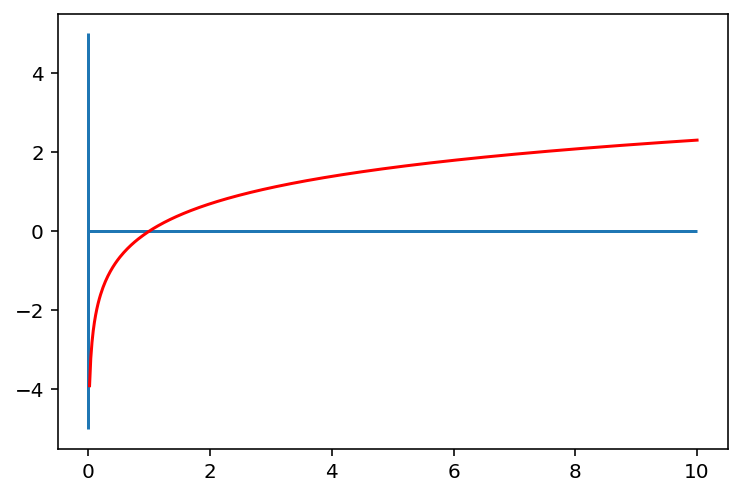

In [126]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

In [136]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

y = data['price']

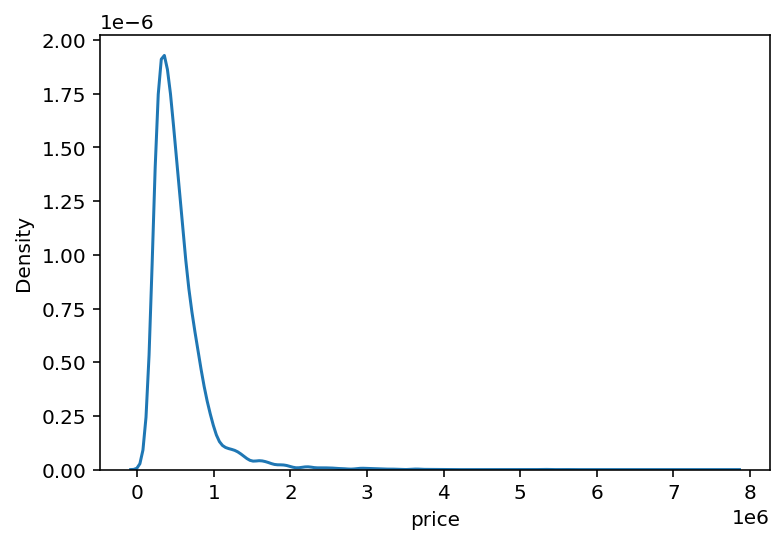

In [135]:
sns.kdeplot(y)
plt.show()

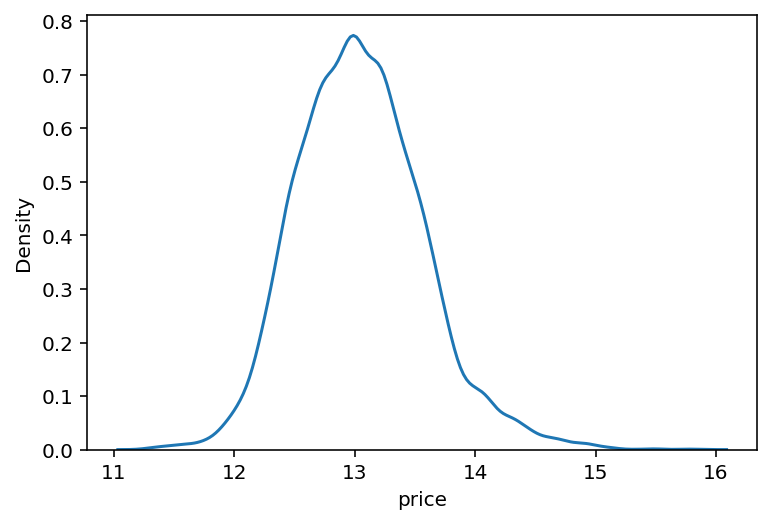

In [138]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [139]:
train_len

15035

In [140]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

In [141]:
sub.shape, x.shape

((6468, 19), (15035, 19))

In [142]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### KFold.get_n_splits
(self, X=None, y=None, groups=None)
>Returns the number of splitting iterations in the cross-validator

### np.mean
(
    a,
    axis=None,
    dtype=None,
    out=None,
    keepdims=<no value>,
    *,
    where=<no value>,
)

In [143]:
def get_cv_score(models):
    kfold = KFold(n_splits= 5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X= x.values, y= y, cv= kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [144]:
x.values

array([['201410', 1.3862943611198906, 1.0, ..., -122.257,
        7.201170883281678, 8.639587799629844],
       ['201502', 1.0986122886681096, 1.0, ..., -122.233,
        7.908754738783246, 8.995040974685022],
       ['201502', 1.3862943611198906, 2.0, ..., -122.045,
        7.496097345175956, 8.92319149068606],
       ...,
       ['201405', 1.3862943611198906, 2.5, ..., -122.346,
        7.333676395657684, 7.31986492980897],
       ['201502', 1.6094379124341003, 2.5, ..., -122.362,
        7.5126175446745105, 8.881975184248867],
       ['201410', 1.0986122886681096, 0.75, ..., -122.299,
        6.928537818164665, 7.213768308118642]], dtype=object)

In [145]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [146]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


In [147]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [148]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [149]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

In [150]:
submission

id   price
0     15035  100000
1     15036  100000
2     15037  100000
3     15038  100000
4     15039  100000
...     ...     ...
6463  21498  100000
6464  21499  100000
6465  21500  100000
6466  21501  100000
6467  21502  100000

[6468 rows x 2 columns]

sub_id = data['id'][train_len:]  
y_pred = AveragingBlending(models, x, y, sub)

>def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
>    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

x = data.iloc[:train_len, :]  
y = data['price']  
sub = pd.read_csv(sub_data_path)

In [151]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result

id         price
0     15035  5.299667e+05
1     15036  4.307262e+05
2     15037  1.361677e+06
3     15038  3.338036e+05
4     15039  3.089006e+05
...     ...           ...
6463  21498  2.478657e+05
6464  21499  4.156358e+05
6465  21500  4.520817e+05
6466  21501  3.415730e+05
6467  21502  4.217251e+05

[6468 rows x 2 columns]

result -> to_csv

In [152]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


In [154]:
pwd

'/aiffel/aiffel/Interactive PYthon NoteBook/8th week'

In [155]:
cd ~

/aiffel


In [156]:
cd data

/aiffel/data


In [157]:
ls

2019-ml-month-2nd-baseline.ipynb  data/


In [158]:
cd ../

/aiffel


In [161]:
cd /aiffel/aiffel

/aiffel/aiffel


In [162]:
ls

 bike_regression/      'Interactive PYthon NoteBook'/   Practice/
 data_analysis_basic/   kaggle_kakr_housing/            stock_prediction/
 data_preprocess/       lost+found/                     time_series_basic/
 data_represent/       'lotto number.ipynb'            'Trying to do a test'/
 data_visualization/    pokemon_eda/                    Untitled.ipynb


In [164]:
cd kaggle_kakr_housing/data

/aiffel/aiffel/kaggle_kakr_housing/data


In [165]:
ls

sample_submission.csv*  submission.csv  test.csv*  train.csv*


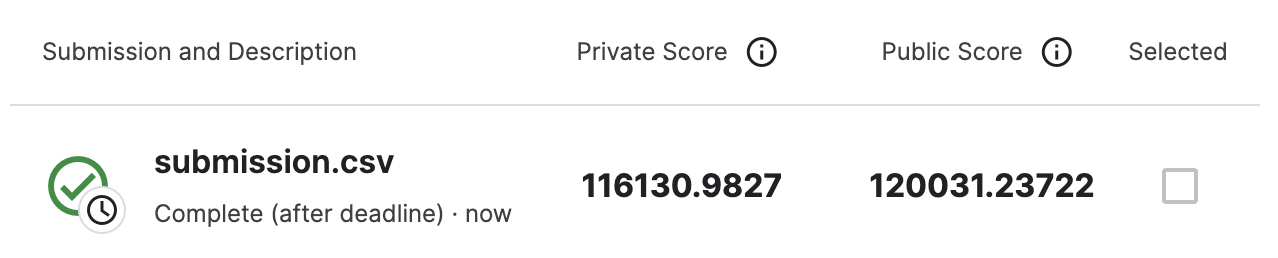

In [167]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [168]:
train

id             date      price  bedrooms  bathrooms  sqft_living  \
0          0  20141013T000000   221900.0         3       1.00         1180   
1          1  20150225T000000   180000.0         2       1.00          770   
2          2  20150218T000000   510000.0         3       2.00         1680   
3          3  20140627T000000   257500.0         3       2.25         1715   
4          4  20150115T000000   291850.0         3       1.50         1060   
...      ...              ...        ...       ...        ...          ...   
15030  15030  20141014T000000   610685.0         4       2.50         2520   
15031  15031  20150326T000000  1007500.0         4       3.50         3510   
15032  15032  20140521T000000   360000.0         3       2.50         1530   
15033  15033  20150223T000000   400000.0         4       2.50         2310   
15034  15034  20141015T000000   325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
0          5650     1.0           0     0  ...      7        1180   
1         10000     1.0           0     0  ...      6         770   
2          8080     1.0           0     0  ...      8        1680   
3          6819     2.0           0     0  ...      7        1715   
4          9711     1.0           0     0  ...      7        1060   
...         ...     ...         ...   ...  ...    ...         ...   
15030      6023     2.0           0     0  ...      9        2520   
15031      7200     2.0           0     0  ...      9        2600   
15032      1131     3.0           0     0  ...      8        1530   
15033      5813     2.0           0     0  ...      8        2310   
15034      1076     2.0           0     0  ...      7        1020   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0                  0      1955             0    98178  47.5112 -122.257   
1                  0      1933             0    98028  47.7379 -122.233   
2                  0      1987             0    98074  47.6168 -122.045   
3                  0      1995             0    98003  47.3097 -122.327   
4                  0      1963             0    98198  47.4095 -122.315   
...              ...       ...           ...      ...      ...      ...   
15030              0      2014             0    98056  47.5137 -122.167   
15031            910      2009             0    98136  47.5537 -122.398   
15032              0      2009             0    98103  47.6993 -122.346   
15033              0      2014             0    98146  47.5107 -122.362   
15034              0      2008             0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  
0               1340        5650  
1               2720        8062  
2               1800        7503  
3               2238        6819  
4               1650        9711  
...              ...         ...  
15030           2520        6023  
15031           2050        6200  
15032           1530        1509  
15033           1830        7200  
15034           1020        1357  

[15035 rows x 21 columns]

data['date'] = data['date'].apply(lambda x : str(x[:6]))

In [174]:
train['date'][0]

'20141013T000000'

In [173]:
train['date'][0][:6]

'201410'

In [175]:
train['date'].apply(lambda i: i[:6])

0        201410
1        201502
2        201502
3        201406
4        201501
          ...  
15030    201410
15031    201503
15032    201405
15033    201502
15034    201410
Name: date, Length: 15035, dtype: object

In [176]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

In [177]:
y = train['price']
del train['price']

In [178]:
del train['id']

In [179]:
train

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0      201410         3       1.00         1180      5650     1.0           0   
1      201502         2       1.00          770     10000     1.0           0   
2      201502         3       2.00         1680      8080     1.0           0   
3      201406         3       2.25         1715      6819     2.0           0   
4      201501         3       1.50         1060      9711     1.0           0   
...       ...       ...        ...          ...       ...     ...         ...   
15030  201410         4       2.50         2520      6023     2.0           0   
15031  201503         4       3.50         3510      7200     2.0           0   
15032  201405         3       2.50         1530      1131     3.0           0   
15033  201502         4       2.50         2310      5813     2.0           0   
15034  201410         2       0.75         1020      1076     2.0           0   

       view  condition  grade  sqft_above  sqft_basement  yr_built  \
0         0          3      7        1180              0      1955   
1         0          3      6         770              0      1933   
2         0          3      8        1680              0      1987   
3         0          3      7        1715              0      1995   
4         0          3      7        1060              0      1963   
...     ...        ...    ...         ...            ...       ...   
15030     0          3      9        2520              0      2014   
15031     0          3      9        2600            910      2009   
15032     0          3      8        1530              0      2009   
15033     0          3      8        2310              0      2014   
15034     0          3      7        1020              0      2008   

       yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0                 0    98178  47.5112 -122.257           1340        5650  
1                 0    98028  47.7379 -122.233           2720        8062  
2                 0    98074  47.6168 -122.045           1800        7503  
3                 0    98003  47.3097 -122.327           2238        6819  
4                 0    98198  47.4095 -122.315           1650        9711  
...             ...      ...      ...      ...            ...         ...  
15030             0    98056  47.5137 -122.167           2520        6023  
15031             0    98136  47.5537 -122.398           2050        6200  
15032             0    98103  47.6993 -122.346           1530        1509  
15033             0    98146  47.5107 -122.362           1830        7200  
15034             0    98144  47.5941 -122.299           1020        1357  

[15035 rows x 19 columns]

In [180]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

In [185]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

### plt.subplots
(
    nrows=1,
    ncols=1,
    *,
    sharex=False,
    sharey=False,
    squeeze=True,
    subplot_kw=None,
    gridspec_kw=None,
    **fig_kw,
)

### sns.kdeplot
(
    x=None,
    *,
    y=None,
    shade=None,
    vertical=False,
    kernel=None,
    bw=None,
    gridsize=200,
    cut=3,
    clip=None,
    legend=True,
    cumulative=False,
    shade_lowest=None,
    cbar=False,
    cbar_ax=None,
    cbar_kws=None,
    ax=None,
    weights=None,
    hue=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    multiple='layer',
    common_norm=True,
    common_grid=False,
    levels=10,
    thresh=0.05,
    bw_method='scott',
    bw_adjust=1,
    log_scale=None,
    color=None,
    fill=None,
    data=None,
    data2=None,
    warn_singular=True,
    **kwargs,
)

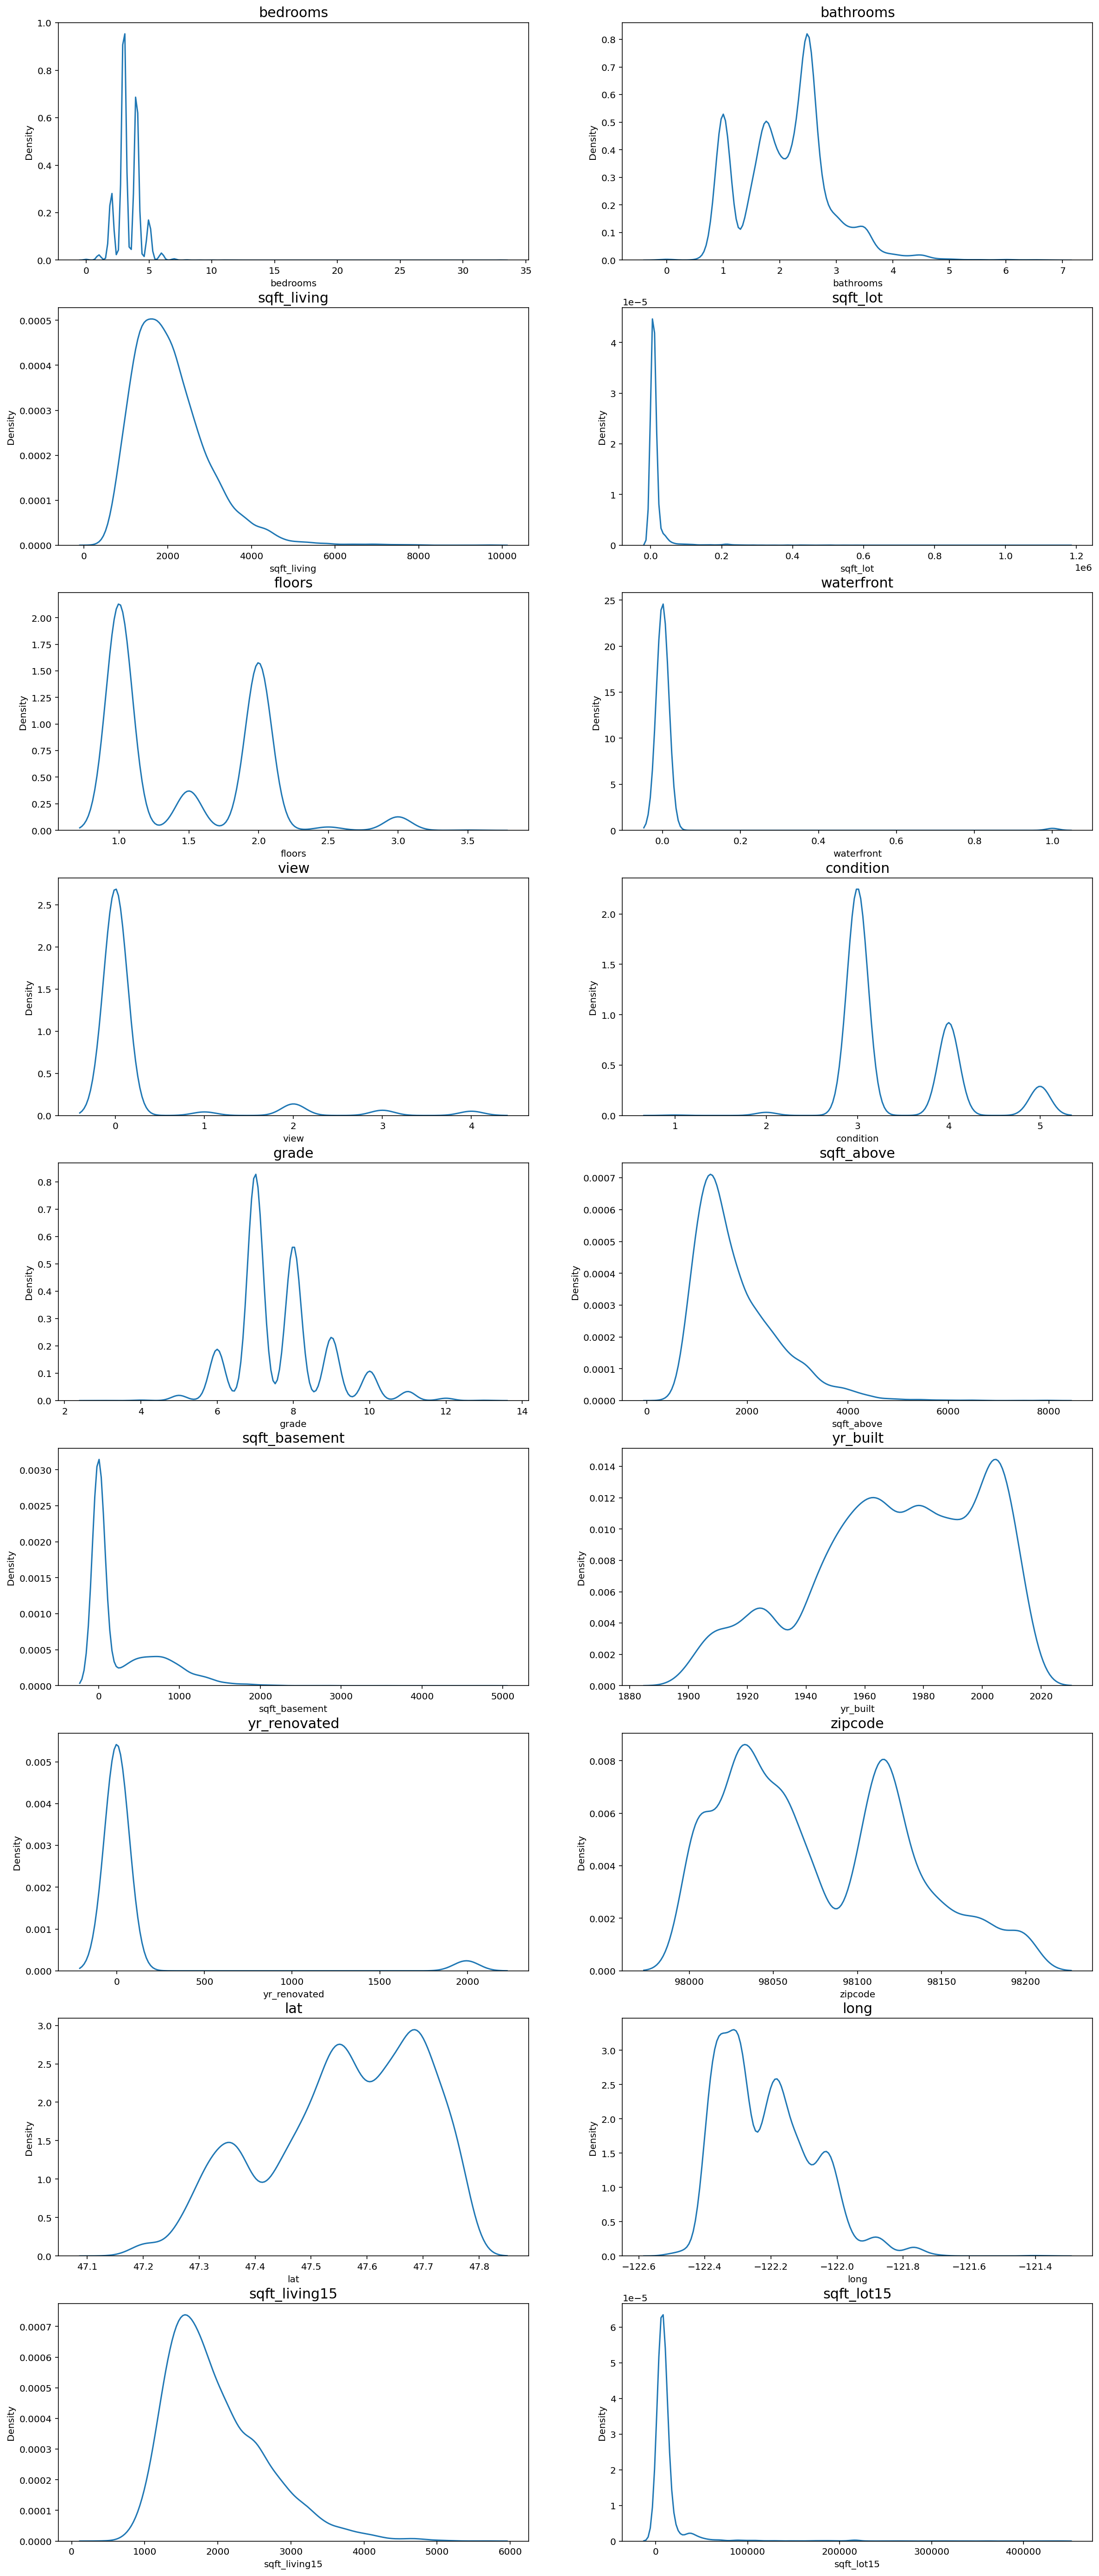

In [189]:
fig, ax = plt.subplots(9, 2, figsize= (20, 50))

count = 1
columns = test.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data= test[columns[count]], ax= ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

Text(0.5, 1.0, 'Price')

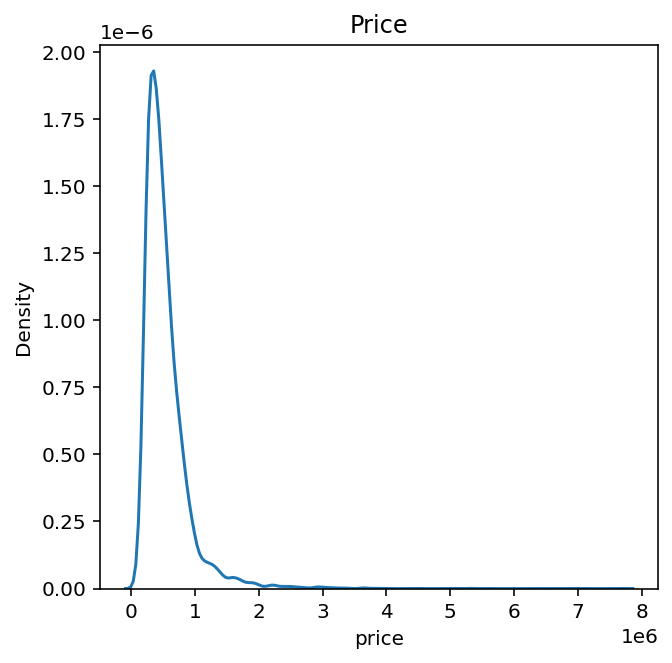

In [197]:
plt.figure(figsize= (5, 5))

sns.kdeplot(data= y);
plt.title("Price")

In [198]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [199]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

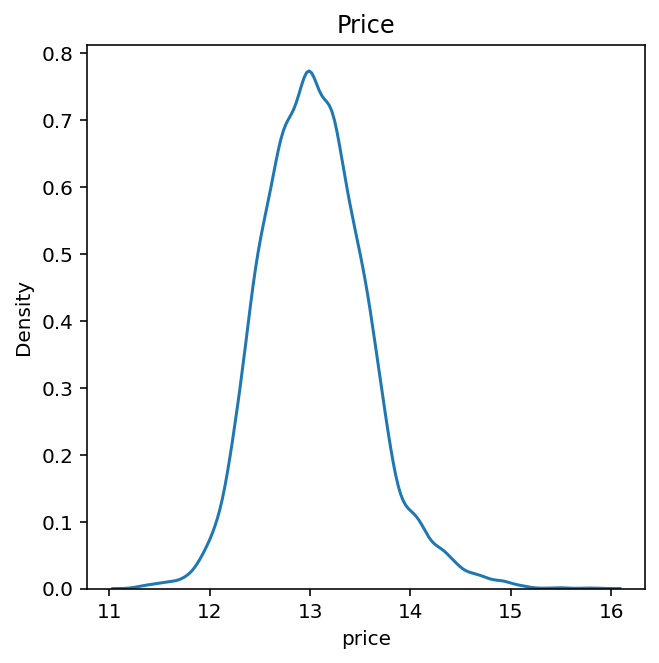

In [200]:
plt.figure(figsize= (5, 5))

plt.title("Price")
sns.kdeplot(data= y);

In [201]:
train.info()
# 모두 실수 또는 정수 자료형으로, 문제 없이 모델 학습에 활용할 수 있을 것 같습니다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [202]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### mean_squared_error 
(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput='uniform_average',
    squared=True,
)

In [203]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

 random_state를 고정값으로 주면 모델과 데이터셋이 동일한 경우  
 머신러닝 학습결과도 항상 동일하게 재현됩니다.

In [204]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [205]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [207]:
gboost.__class__

sklearn.ensemble._gb.GradientBoostingRegressor

In [206]:
gboost.__class__.__name__

'GradientBoostingRegressor'

''가 있다. 그래서 df[model_name] 해도 잘 적용된다. 

In [212]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, 
                                                        random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [216]:
df[model_name]

125487.07102453562

In [214]:
score_df

RMSE
GradientBoostingRegressor  128360.196497
RandomForestRegressor      125487.071025
LGBMRegressor              111920.367359
XGBRegressor               110318.669566

In [217]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, 
                                                            random_state=random_state, 
                                                            test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

RMSE
GradientBoostingRegressor  128360.196497
RandomForestRegressor      125487.071025
LGBMRegressor              111920.367359
XGBRegressor               110318.669566

### Grid Search 
정해진 하이퍼 파라미터의 조합을 격자와 같이 탐색
> search 공간이 제한적
### Random Search
랜덤으로 점을 찍어서 탐색
> search 공간이 훨씬 넓다  

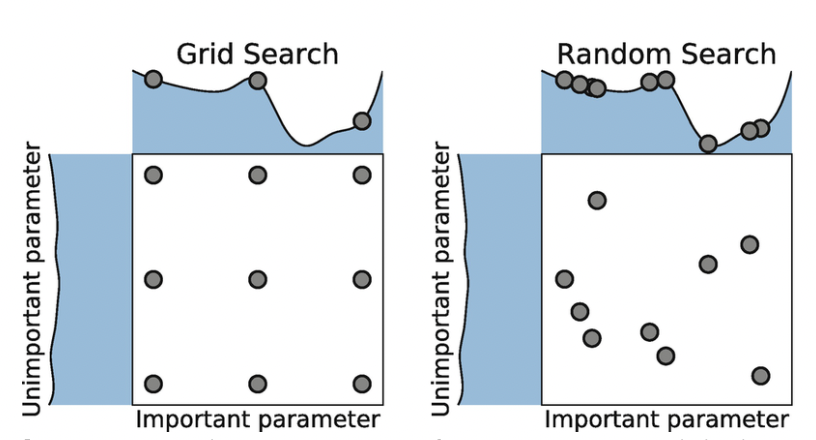

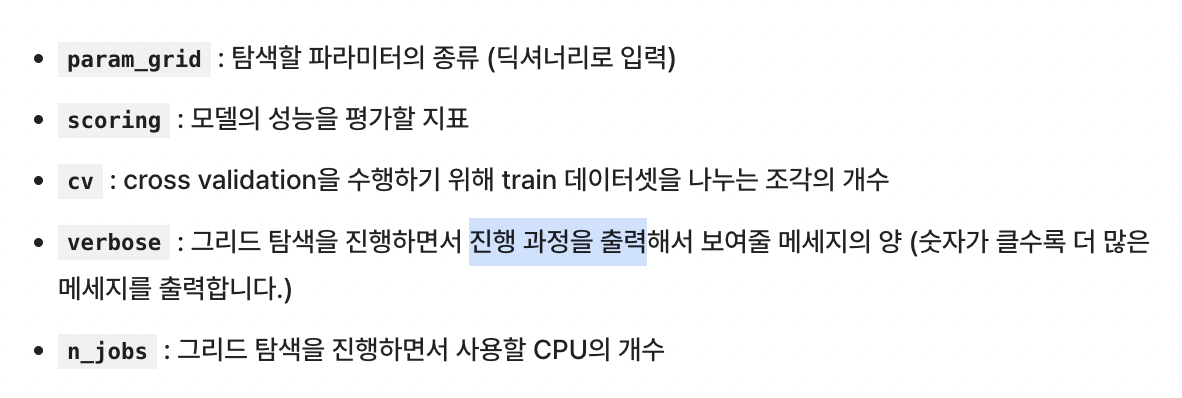

In [218]:
from sklearn.model_selection import GridSearchCV

In [219]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [222]:
param_grid

{'n_estimators': [50, 100], 'max_depth': [1, 10]}

In [223]:
model = LGBMRegressor(random_state=random_state)

In [224]:
model

LGBMRegressor(random_state=2020)

### GridSearchCV
(
    estimator,
    param_grid,
    *,
    scoring=None,
    n_jobs=None,
    refit=True,
    cv=None,
    verbose=0,
    pre_dispatch='2*n_jobs',
    error_score=nan,
    return_train_score=False,
)

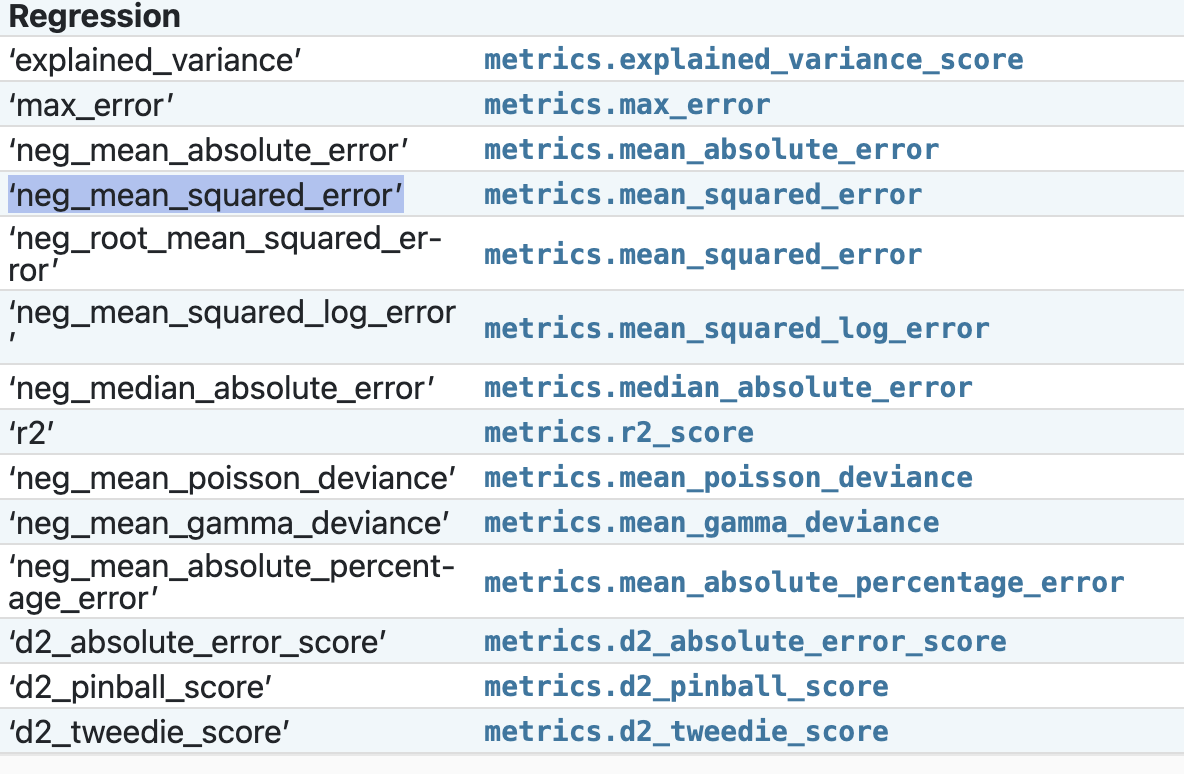  
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [228]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

### param_grid = 
'n_estimators': [50, 100] * 'max_depth': [1, 10]  
>2 * 2  = 4가지 조합

### cv = 5
> corss validation

4 * 5 = 20 --> totalling 20  --> 20 fits

#### cross validation을 5번 진행하는 이유는, 
각 조합에 대해 단 한 번만 실험을 하는 것보다  
5번을 진행해서 평균을 취하는 것이 일반화 오차를 추정하는 데에 더 신뢰도가 높기 때문입니다.  
간단하게, 한 번만 해 보는 것보다는 다섯 번을 해보고 구한 평균값이 더 정확하겠죠!

dir(grid_model)  
>'cv_results_'

In [229]:
# GridSearchCV
grid_model.cv_results_

{'mean_fit_time': array([0.45936203, 0.58976111, 1.1345531 , 1.58047304]),
 'std_fit_time': array([0.05108908, 0.05087704, 0.22377319, 0.09781105]),
 'mean_score_time': array([0.0288693 , 0.0570859 , 0.08086896, 0.07639666]),
 'std_score_time': array([0.01241546, 0.01604596, 0.01956982, 0.04622472]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

>'params':  
[{'max_depth': 1, 'n_estimators': 50},  
  {'max_depth': 1, 'n_estimators': 100},  
  {'max_depth': 10, 'n_estimators': 50},  
  {'max_depth': 10, 'n_estimators': 100}],

In [230]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

'mean_test_score': 
>array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [231]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

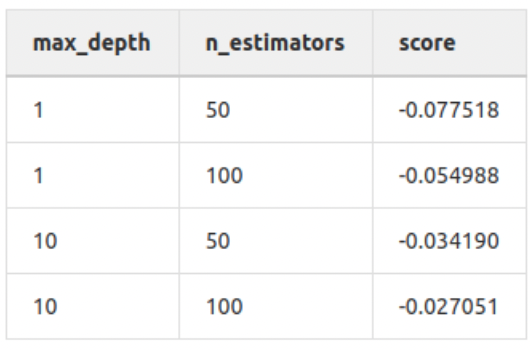

In [232]:
results = pd.DataFrame(params)
results['score'] = score

results

max_depth  n_estimators     score
0          1            50 -0.073394
1          1           100 -0.055020
2         10            50 -0.029177
3         10           100 -0.027027

음수로 된 MSE였으니, -1

In [233]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

max_depth  n_estimators     score      RMSE
0          1            50 -0.073394  0.270914
1          1           100 -0.055020  0.234564
2         10            50 -0.029177  0.170814
3         10           100 -0.027027  0.164399

그리드 탐색을 하면서는  
np.expm1()으로 변환하는 과정이 없었기 때문에   
log 변환되어 있는 price 데이터에서 손실함수값을 계산

 RMSLE, 즉 Root Mean Squared Log Error

In [234]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

max_depth  n_estimators     score     RMSLE
0          1            50 -0.073394  0.270914
1          1           100 -0.055020  0.234564
2         10            50 -0.029177  0.170814
3         10           100 -0.027027  0.164399

### results.sort_values
(
    by,
    axis: 'Axis' = 0,
    ascending=True,
    inplace: 'bool' = False,
    kind: 'str' = 'quicksort',
    na_position: 'str' = 'last',
    ignore_index: 'bool' = False,
    key: 'ValueKeyFunc' = None,
)

In [236]:
results.sort_values(by= "RMSLE", ascending= True, inplace= True)

In [237]:
results

max_depth  n_estimators     score     RMSLE
3         10           100 -0.027027  0.164399
2         10            50 -0.029177  0.170814
1          1           100 -0.055020  0.234564
0          1            50 -0.073394  0.270914

In [238]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

import lightgbm as lgb

dir(lgb)  
>'LGBMRegressor',

In [240]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


max_depth  n_estimators     score     RMSLE
3         10           100 -0.027027  0.164399
2         10            50 -0.029177  0.170814
1          1           100 -0.055020  0.234564
0          1            50 -0.073394  0.270914

In [241]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

np.log1p -> np.expm1

In [242]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [243]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission

id   price
0     15035  100000
1     15036  100000
2     15037  100000
3     15038  100000
4     15039  100000
...     ...     ...
6463  21498  100000
6464  21499  100000
6465  21500  100000
6466  21501  100000
6467  21502  100000

[6468 rows x 2 columns]

In [244]:
submission['price'] = prediction

In [245]:
submission

id         price
0     15035  5.067667e+05
1     15036  4.795061e+05
2     15037  1.345155e+06
3     15038  3.122579e+05
4     15039  3.338645e+05
...     ...           ...
6463  21498  2.328743e+05
6464  21499  4.038553e+05
6465  21500  4.495159e+05
6466  21501  3.274029e+05
6467  21502  4.263327e+05

[6468 rows x 2 columns]

In [246]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)

In [248]:
submission_csv_path

'/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv'

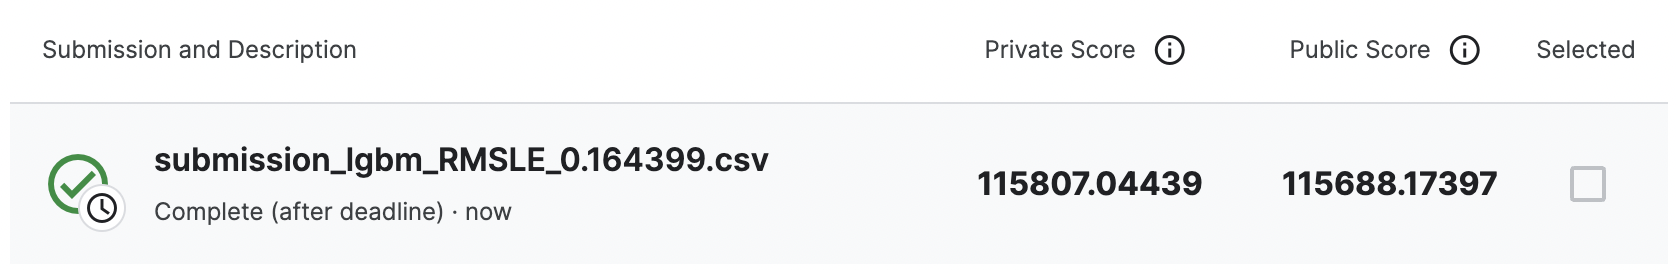

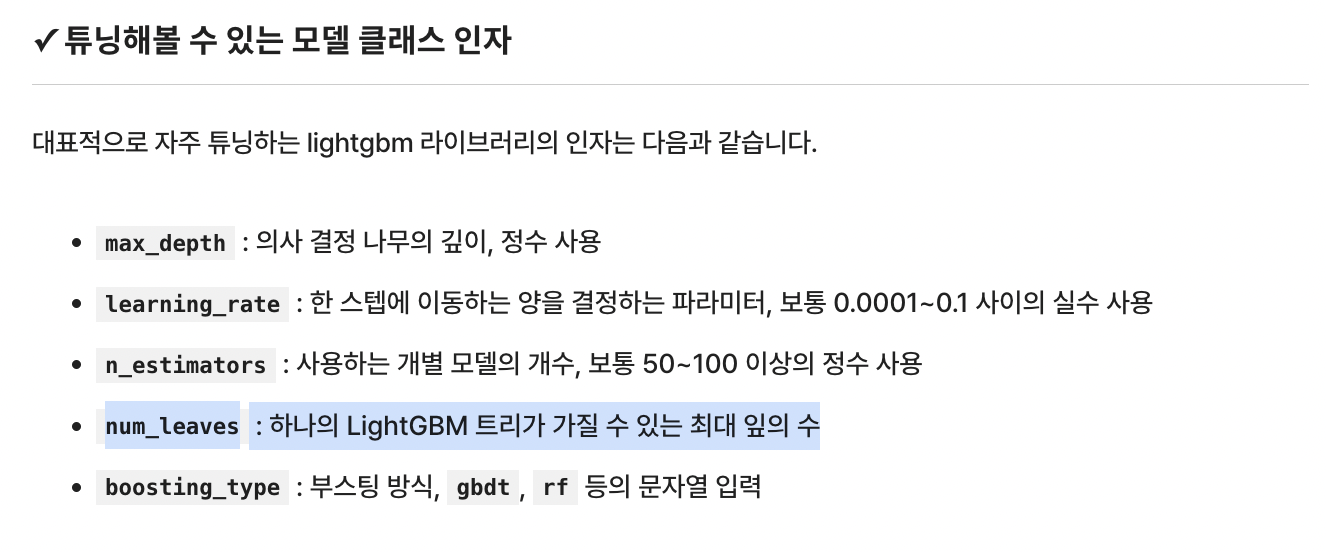

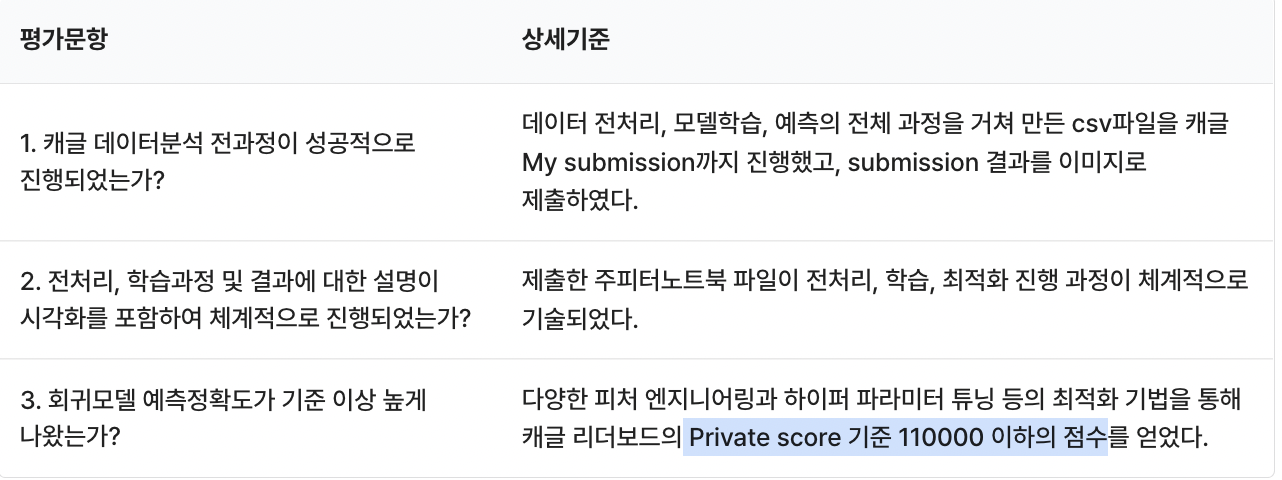

In [249]:
from sklearn.model_selection import RandomizedSearchCV

### sklearn.model_selection.RandomizedSearchCV  
(estimator, param_distributions, *, n_iter=10, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score=nan, return_train_score=False)

In [250]:
dir(RandomizedSearchCV)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_select_best_index',
 '_validate_data',
 'classes_',
 'decision_function',
 'fit',
 'get_params',
 'inverse_transform',
 'n_features_in_',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'score',
 'score_samples',
 'set_params',
 'transform']

In [ ]:
rsc = RandomizedSearchCV()